### Imports 

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import chess
import torch
import sys
import os

from tqdm import tqdm 

### Reading Files and Processing

In [2]:
# Count lines
file_path = "../../data/raw/lichess_eval/lichess_db_eval.jsonl"

print(f"Processing file: {file_path}")
STOP_NUMBER = 1000000
total_lines = 0
with open(file_path, 'r') as file:
    for _ in file:
        if total_lines >= STOP_NUMBER:
            break
        total_lines += 1

print(f"Total lines to process: {total_lines}")



Processing file: ../../data/raw/lichess_eval/lichess_db_eval.jsonl
Total lines to process: 1000000


In [3]:
processed_data = []
total_lines = 0
with open(file_path, 'r') as file:
    
    for line in tqdm(file, total=total_lines, desc="Processing lines"):
        total_lines += 1
        if total_lines >= STOP_NUMBER:
            break
        try:
            obj = json.loads(line.strip())
            fen = obj.get('fen')
            
            cp = None
            # Extract cp from first pvs item
            if obj.get('evals') and len(obj['evals']) > 0:
                if obj['evals'][0].get('pvs') and len(obj['evals'][0]['pvs']) > 0:
                    cp_value = obj['evals'][0]['pvs'][0].get('cp')
                    if cp_value is not None: # Ensure cp_value itself is not None
                        cp = int(cp_value) # Convert cp to integer if it's not None

            # Only append if cp is not None 
            if cp is not None:
                processed_data.append({'fen': fen, 'cp': cp})
        except json.JSONDecodeError:
            print(f"Skipping line due to JSON decode error: {line.strip()}")
        except Exception as e:
            print(f"Skipping line due to other error: {e} - Line: {line.strip()}")


# Create DataFrame from the processed data
df = pd.DataFrame(processed_data)

print(f"\nFinished processing.")
print(f"Total entries processed and kept: {len(df)}")

Processing lines: 999999it [00:13, 73068.78it/s]



Finished processing.
Total entries processed and kept: 829355


### Save df to file

In [4]:
if not df.empty:
    output_file_path = '../../data/interim/lichess_eval/lichess_db_eval.parquet'
    df.to_parquet(output_file_path)
    print(f"\nDataFrame saved to {output_file_path}")
else:
    print("DataFrame is empty. Nothing to save.")


DataFrame saved to ../../data/interim/lichess_eval/lichess_db_eval.parquet


### Additional Processing for NN Training

In [6]:

project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src.io.to_tensor import create_tensor  # Assumes this is the correct import path based on document_3
from tqdm import tqdm


# Load the Parquet file (assumes it's already created earlier in the notebook)
parquet_path = '../../data/interim/lichess_eval/lichess_db_eval.parquet'
df = pd.read_parquet(parquet_path)
print(f"Loaded {len(df)} entries from {parquet_path}")

# Configuration
SAMPLE_SIZE = 100000  # Adjust as needed (e.g., full size or smaller for testing)
MAX_CP = 2000.0  # Matches MAX_EVAL * 100 from simple_nn_eval.py (20.0 pawns = 2000 centipawns)

# Sample if needed
if SAMPLE_SIZE and SAMPLE_SIZE < len(df):
    df = df.sample(n=SAMPLE_SIZE, random_state=42)
    print(f"Sampled {SAMPLE_SIZE} entries for processing.")

# Process data
tensors = []
labels = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing FEN to tensors"):
    fen = row['fen']
    cp = row['cp']
    try:
        # Create chess board from FEN
        board = chess.Board(fen)
        
        # Convert to tensor (shape: [NUM_PLANES, 8, 8])
        tensor = create_tensor(board)
        tensors.append(tensor)
        
        # Normalize label: Clip CP and scale to [-1, 1]
        clipped_cp = max(min(cp, MAX_CP), -MAX_CP)
        normalized_label = clipped_cp / MAX_CP
        labels.append(normalized_label)
    except ValueError as e:
        print(f"Skipping invalid FEN '{fen}': {e}")
    except Exception as e:
        print(f"Error processing FEN '{fen}': {e}")

# Convert to PyTorch tensors
if tensors:
    input_tensors = torch.stack(tensors)  # Shape: [num_samples, NUM_PLANES, 8, 8]
    label_tensors = torch.tensor(labels, dtype=torch.float32).unsqueeze(1)  # Shape: [num_samples, 1]
    
    # Save as a dictionary for easy loading
    processed_data = {'inputs': input_tensors, 'labels': label_tensors}
    output_tensor_path = '../../data/processed/lichess_eval/lichess_processed.pt'
    torch.save(processed_data, output_tensor_path)
    print(f"Processed data saved to {output_tensor_path}. Inputs shape: {input_tensors.shape}, Labels shape: {label_tensors.shape}")
else:
    print("No valid data processed. Check FENs and dependencies.")

Loaded 829355 entries from ../../data/interim/lichess_eval/lichess_db_eval.parquet
Sampled 100000 entries for processing.


Processing FEN to tensors:   0%|          | 267/100000 [00:00<02:51, 580.70it/s]

Skipping invalid FEN 'rnnkrqbb/ppppp1pp/8/4Pp2/8/8/PPPP1PPP/RNNKRQBB b KQkq -': Invalid board state
Skipping invalid FEN 'rbbnqrkn/pp2pppp/2p5/3p3P/2PP4/6N1/PP2PPP1/RBBNQ1KR w KQ -': Invalid board state
Skipping invalid FEN 'rnb2rk1/pp3pbp/3p1np1/2pP2N1/2P1Pp2/2N3P1/PP4BP/R1BR2K1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/p2pqppp/1p1Np3/n6n/1PP5/P2Q1b2/4PPPP/R3KB1R w KQq -': Invalid board state


Processing FEN to tensors:   1%|          | 648/100000 [00:01<01:56, 856.02it/s]

Skipping invalid FEN 'r1b2rk1/3pppbp/2n3p1/p1q4n/P1N5/2P1PNB1/1PQ2PPP/R3KB1R b KQq -': Invalid board state
Skipping invalid FEN 'rbbkqnrn/pppppppp/8/8/3P4/8/PPP1PPPP/RBBKQNRN b KQkq -': Invalid board state


Processing FEN to tensors:   1%|          | 839/100000 [00:01<01:50, 897.98it/s]

Skipping invalid FEN '1qrknbbr/pppppppp/1n6/8/3PP3/8/PPP2PPP/NQRKNBBR b KQkq -': Invalid board state


Processing FEN to tensors:   1%|          | 1235/100000 [00:01<01:41, 969.51it/s]

Skipping invalid FEN 'rn3rk1/pp2Nqp1/2p1Rb1p/8/8/1Q1P4/PP3PPP/R1B3K1 b Qq -': Invalid board state


Processing FEN to tensors:   2%|▏         | 1644/100000 [00:02<01:36, 1014.62it/s]

Skipping invalid FEN 'r4rk1/p4ppp/2p1p3/bq1p4/N2Q4/4P2P/PPP2PP1/R4RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/1bqn1pp1/pp1b1n1p/2pP1Q2/P1B5/1PN2N2/5PPP/R1B1R1K1 b Qq -': Invalid board state


Processing FEN to tensors:   2%|▏         | 1957/100000 [00:02<01:35, 1030.76it/s]

Skipping invalid FEN 'r5k1/pp1r1pb1/2p3p1/4p2p/P3P3/2P1BP2/1PK3PP/R6R w q -': Invalid board state
Skipping invalid FEN '1k6/pppppppp/8/PPPPpPPP/1pppPppp/8/PPPPPPPP/K7 w - -': Invalid board state
Skipping invalid FEN 'rnb2rk1/1pp1q1pp/p3p3/5pN1/3Pp3/5P2/PPPQB1PP/R3K2R b KQq -': Invalid board state


Processing FEN to tensors:   2%|▏         | 2379/100000 [00:02<01:36, 1009.16it/s]

Skipping invalid FEN 'rn1q1rk1/ppp1ppbp/3p1np1/5b2/2PP4/2N1P3/PP1NBPPP/R1BQK2R b KQq -': Invalid board state


Processing FEN to tensors:   3%|▎         | 2581/100000 [00:03<01:39, 983.09it/s] 

Skipping invalid FEN 'r1b2rk1/ppp2ppp/2p5/8/4q3/1N2B3/PPP2PPP/R2QK2R b KQq -': Invalid board state


Processing FEN to tensors:   3%|▎         | 2880/100000 [00:03<01:37, 991.05it/s]

Skipping invalid FEN '2kr4/1pp3pp/p1pb1p2/6n1/4r1P1/PP1R3P/1BP2PN1/2K4R w K -': Invalid board state


Processing FEN to tensors:   3%|▎         | 3184/100000 [00:03<01:36, 1000.67it/s]

Skipping invalid FEN 'qb1r1rk1/pb2pppp/1p3nn1/2pp4/2PP4/1P1B1NN1/P3PPPP/1QBR1KR1 w KQ -': Invalid board state


Processing FEN to tensors:   4%|▎         | 3599/100000 [00:04<01:33, 1026.41it/s]

Skipping invalid FEN 'rnb3k1/1p2r1p1/3b1BR1/p5Q1/5P2/1P6/P2q2PP/5RK1 b q -': Invalid board state


Processing FEN to tensors:   4%|▍         | 4206/100000 [00:04<01:35, 999.08it/s] 

Skipping invalid FEN 'nbbnrqkr/p1pppppp/1p6/8/8/1N6/PPPPPPPP/1BBNRQKR w KQkq -': Invalid board state


Processing FEN to tensors:   4%|▍         | 4409/100000 [00:04<01:35, 1005.51it/s]

Skipping invalid FEN 'r1bq1rk1/2p1bppp/p1n5/1p1nN3/8/1BP5/PP1P1PPP/RNBQR1K1 b Qq -': Invalid board state
Skipping invalid FEN 'r1bqk2r/ppp2pp1/2n2n1p/2B5/2B1p3/2N5/PPP1Q1PP/R4RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rbqnbkrn/pppppppp/8/8/8/8/PPPPPPPP/RBQNBKRN w KQkq -': Invalid board state


Processing FEN to tensors:   5%|▌         | 5163/100000 [00:05<01:31, 1034.27it/s]

Skipping invalid FEN 'r2q1rk1/p1pn2pp/1p1p4/3b1p2/4n3/P4NP1/1PQ1PPBP/R1B2RK1 w Qq -': Invalid board state
Skipping invalid FEN 'brqbnrk1/pppp1ppp/6n1/4p3/4P3/1P6/PQPP1PPP/BR1BNNKR w KQ -': Invalid board state
Skipping invalid FEN 'r5k1/ppp2p2/3b1p1p/8/2qPr2N/6P1/5P1P/R2Q1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pbpn2pp/1p1p4/3p1p2/2P1n3/P4NP1/1PQ1PPBP/R1B2RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rn1qk2r/ppp2pp1/5n1p/2B5/2B1p1b1/2N1Q3/PPP3PP/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r3k2r/1bq2p1p/p3nbpN/1p1Np3/4P1P1/P7/1PP1Q1BP/R1B3K1 b Qkq -': Invalid board state


Processing FEN to tensors:   6%|▌         | 5572/100000 [00:05<01:34, 999.12it/s] 

Skipping invalid FEN 'r3kb1r/ppp2ppp/4b3/4R3/2qP4/5Q2/PP3PPP/R1B3K1 w Qkq -': Invalid board state
Skipping invalid FEN 'r1q2nk1/p5p1/Rpn1p2p/1P1pPp1P/2rP1N2/4B2R/2P2PP1/1Q1K4 w q -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/pp1bppb1/3p1np1/2pP3p/2P1P3/2N4P/PP1NBPP1/R1BQK2R b KQq -': Invalid board state


Processing FEN to tensors:   6%|▌         | 5772/100000 [00:06<01:37, 964.16it/s]

Skipping invalid FEN '1rbq1rk1/1p3ppp/p2p1N2/4p3/2PpP3/1Q1P4/PP2BPPP/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:   6%|▌         | 6180/100000 [00:06<01:33, 1000.63it/s]

Skipping invalid FEN 'qrk2r2/ppp1ppbp/4nnp1/Pb1p4/1B1P4/4P1P1/1PP2P1P/QRKNR1NB b Qkq -': Invalid board state
Skipping invalid FEN 'rnbq2k1/pp1p4/6Np/2p5/1b2BBP1/2NP1rP1/PPP2P2/R3K2R b KQq -': Invalid board state
Skipping invalid FEN 'rnbqr1k1/pp1nbp1p/4p1pQ/2ppP1B1/3P3P/2NB4/PPP2PP1/R3K1NR w KQq -': Invalid board state
Skipping invalid FEN '8/pb2bk1p/pp2pppp/2p5/PP1nP1pP/P1NB2P1/1PPN1PPP/5RK1 b - -': Invalid board state


Processing FEN to tensors:   6%|▋         | 6484/100000 [00:06<01:34, 993.99it/s] 

Skipping invalid FEN 'r1bq1rk1/pp3ppp/2nb1n2/1Bppp3/4P3/1P1P1N2/PBPN1PPP/R2QK2R w KQq -': Invalid board state
Skipping invalid FEN 'r1b2r2/ppp1k1pp/3p1n2/5p1q/2PQ4/1P4P1/P3PPBP/R1B2RK1 w Q -': Invalid board state


Processing FEN to tensors:   7%|▋         | 6781/100000 [00:07<01:36, 963.51it/s]

Skipping invalid FEN 'qnrnkbbr/pppppppp/8/8/3P4/8/PPP1PPPP/QNRNKBBR b KQkq -': Invalid board state


Processing FEN to tensors:   7%|▋         | 7181/100000 [00:07<01:33, 990.62it/s]

Skipping invalid FEN '1k1r1r2/p1pq2pp/1p2p1n1/2P1p3/8/Q3BbP1/PP3P1P/R3RBK1 w Q -': Invalid board state
Skipping invalid FEN 'q1rkbnr1/ppp1ppbp/2np2p1/8/5PP1/2PPN3/PP2P2P/QNRKB1RB b KQkq -': Invalid board state


Processing FEN to tensors:   8%|▊         | 7586/100000 [00:08<01:32, 1002.36it/s]

Skipping invalid FEN '2krb1nr/pp3Np1/1q2p1Bp/2bpP2Q/8/8/PP3PPP/R1B2RK1 b Q -': Invalid board state
Skipping invalid FEN 'r4rk1/p4pp1/1p2q2p/1np1pNb1/4P3/3P3P/PP2QPP1/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r3r1k1/p4ppp/1pp2n2/5P2/2bq2n1/B1P4P/P3N1P1/RN3RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/p7/q1p3p1/2Q5/2P2p2/3b4/PP1B1KPP/2R4R b q -': Invalid board state
Skipping invalid FEN 'r1b1q1kr/pp3p1p/1bn1p2B/3QP2p/4N3/8/PPP2PPP/R3K2R b KQkq -': Invalid board state


Processing FEN to tensors:   8%|▊         | 7994/100000 [00:08<01:31, 1007.95it/s]

Skipping invalid FEN 'r1bq1k1r/pp4b1/P2p1nn1/1B1Pp2p/4P1p1/2N2pP1/1P1B1P1P/R1NQK2R b KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/p1nq2b1/1p1p1np1/1PpPp2p/Q1P1P2P/P1N2NPb/1K1BB3/3R2R1 b q -': Invalid board state
Skipping invalid FEN 'rknnbbrq/pppppppp/8/8/8/8/PPPPPPPP/RKNNBBRQ w KQkq -': Invalid board state
Skipping invalid FEN 'r1bqr3/p1p3kp/2pb2p1/5p2/3B4/1P4NP/P2P1PP1/R2Q1RK1 b Q -': Invalid board state
Skipping invalid FEN 'r1b1r1k1/p1p2ppp/5q2/bp1P4/Q1B1P3/8/P2N1PPP/R4R1K w Qq -': Invalid board state


Processing FEN to tensors:   9%|▊         | 8609/100000 [00:09<01:30, 1013.93it/s]

Skipping invalid FEN '4kb1r/p2q1ppp/5n2/4p1B1/4P3/1Q6/PPP2PPP/2K4R w Kk -': Invalid board state
Skipping invalid FEN '4rrk1/pp3ppp/2n1pn2/q1pp1N2/5P2/PP1PPQP1/1BP4P/2KR1B1R w Kq -': Invalid board state
Skipping invalid FEN 'r3k2r/pp2nppp/2p5/4b3/3NP1n1/3BB1P1/PPP4P/2KR3R w Kkq -': Invalid board state


Processing FEN to tensors:   9%|▉         | 9119/100000 [00:09<01:30, 1003.69it/s]

Skipping invalid FEN 'rbbn1nkr/p1p1pppp/8/1q1p4/3P4/8/PP2PPPP/RBBNQNKR w KQkq -': Invalid board state
Skipping invalid FEN 'rn1r2k1/1b2bppp/4pn2/p1p5/NpP5/PP3NP1/1B2PPBP/R2R2K1 b Qq -': Invalid board state


Processing FEN to tensors:   9%|▉         | 9321/100000 [00:09<01:30, 1004.31it/s]

Skipping invalid FEN '5rk1/q3ppbp/r2n2p1/3pNb2/PQ1P1B2/4P2P/3N1PP1/R1R3K1 b Q -': Invalid board state
Skipping invalid FEN 'r1b2rk1/pp2q1p1/5p2/3p4/7Q/3BPN1P/PP3P2/6RK b q -': Invalid board state


Processing FEN to tensors:  10%|▉         | 9737/100000 [00:10<01:27, 1034.55it/s]

Skipping invalid FEN 'r1b1qrk1/ppp2pb1/n2p2pp/2P1p1B1/3PP1n1/2N2N2/PP2BPPP/R2Q1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  10%|█         | 10155/100000 [00:10<01:26, 1034.73it/s]

Skipping invalid FEN 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPPPPPP/RNBQKBNR b KQkq -': Invalid board state


Processing FEN to tensors:  10%|█         | 10465/100000 [00:10<01:28, 1009.77it/s]

Skipping invalid FEN '1Q3k1r/4b3/1pq1B1p1/2PpP3/r4P2/B1P3R1/R6P/6K1 b k -': Invalid board state
Skipping invalid FEN 'rkbnr1nq/ppppp1bp/6p1/5p2/8/1PN3P1/PBPPPP1P/RK2RBNQ b KQkq -': Invalid board state


Processing FEN to tensors:  11%|█         | 10667/100000 [00:11<01:29, 994.09it/s] 

Skipping invalid FEN 'rnbq1rk1/1p2bppp/4p3/p1pN4/8/1P3NP1/P2PPPBP/R1BQ1RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r1bqrbk1/pp3ppp/8/2n1p3/2Pp4/1P1P2P1/PB2RPBP/RN2Q1K1 w Qq -': Invalid board state


Processing FEN to tensors:  11%|█         | 10982/100000 [00:11<01:26, 1024.92it/s]

Skipping invalid FEN '4qk1r/r3bp2/p4p2/1p1R1N1p/8/8/PP1Q1PPP/R5K1 w Q -': Invalid board state


Processing FEN to tensors:  11%|█         | 11188/100000 [00:11<01:27, 1015.93it/s]

Skipping invalid FEN 'rbk4q/1p4pp/2p2R2/p1B1Q3/P3n3/6P1/1PPPP2P/RBK5 b Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/pp1bq1bn/3p4/1NpPnp2/P3PB1p/8/1P1QBNPP/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r3kb1r/1p1npppp/p1n3b1/6N1/6P1/2N1B3/PP2BP1P/3RK2R w KQkq -': Invalid board state


Processing FEN to tensors:  12%|█▏        | 11589/100000 [00:11<01:29, 986.47it/s] 

Skipping invalid FEN '2kr2n1/ppp2pPp/4bq2/8/2pN4/8/PPP2PPP/R2QR1K1 w Q -': Invalid board state


Processing FEN to tensors:  12%|█▏        | 11889/100000 [00:12<01:28, 990.48it/s]

Skipping invalid FEN '4r1k1/p1p1rp1p/2pn2p1/8/8/2N4P/PPP2PP1/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN 'r1bq1bk1/pppn1p1p/5p2/3p1Q2/3Pr3/B1P5/2BN1PPP/R3R1K1 w Qq -': Invalid board state


Processing FEN to tensors:  12%|█▏        | 12192/100000 [00:12<01:30, 970.28it/s]

Skipping invalid FEN '1rr3k1/1p2ppbp/3p2p1/3Pn3/4P3/5P2/PP1RBBPP/R5K1 w Q -': Invalid board state
Skipping invalid FEN 'brqb1rk1/p1p2pp1/1p1p1np1/4p3/4P3/1P4NP/PQPP1PP1/BR2N1KR w KQ -': Invalid board state
Skipping invalid FEN 'r1b1kbnr/p4ppp/1pn1p3/2p5/4P3/5NP1/PPP2PBP/RNBK3R w KQkq -': Invalid board state
Skipping invalid FEN '2r1kb1r/pp1nnpp1/1qp1p2p/4P3/2QP1P2/2N2N2/PP4PP/R1B2RK1 w Qk -': Invalid board state


Processing FEN to tensors:  12%|█▏        | 12489/100000 [00:12<01:29, 976.46it/s]

Skipping invalid FEN 'r3rbk1/pppq1ppp/3p1n2/8/2PQP3/1PN5/PB3PPP/3R1RK1 b q -': Invalid board state
Skipping invalid FEN '4r1kr/p1Q2R2/p1pN2p1/2q3Np/PP2p3/K7/2P2PP1/8 b k -': Invalid board state


Processing FEN to tensors:  13%|█▎        | 12684/100000 [00:13<01:30, 960.80it/s]

Skipping invalid FEN '2kr1b1r/1b1n1p2/1qp1p2p/pp1nP1p1/P1pPN3/2N3B1/1P2BPPP/R2Q1RK1 w Qk -': Invalid board state
Skipping invalid FEN 'brknrbqn/pppppppp/8/8/8/8/PPPPPPPP/BRKNRBQN w KQkq -': Invalid board state
Skipping invalid FEN 'rn1k1Qnr/1b1p1Bpp/p7/4N3/4pq2/8/PP3PPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'rnkqnbbr/pppp1ppp/8/8/3p4/2P5/PP2PPPP/RNKQNBBR w KQkq -': Invalid board state
Skipping invalid FEN '2kr3r/pp4pp/2pb3q/3p4/2Pp1n2/1B1P1N2/PP3P1P/4RQRK b k c3': Invalid board state


Processing FEN to tensors:  13%|█▎        | 12978/100000 [00:13<01:30, 966.24it/s]

Skipping invalid FEN 'nrknbrqb/pppppppp/8/8/8/8/PPPPPPPP/NRKNBRQB w KQkq -': Invalid board state
Skipping invalid FEN 'r5k1/3nr2p/2qp2pB/2p1p1N1/2P5/3Q3P/5PP1/5RK1 w q -': Invalid board state


Processing FEN to tensors:  14%|█▎        | 13562/100000 [00:14<01:30, 952.62it/s]

Skipping invalid FEN 'r2q1rk1/ppp1nppp/3pn3/4p3/4P3/2PPB3/PPQ1BPPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN '1brkrnbq/pp1p3p/1np2pp1/4p3/4P3/1N2NP2/PPPP2PP/1BKRR1BQ w kq -': Invalid board state


Processing FEN to tensors:  14%|█▍        | 14044/100000 [00:14<01:33, 917.28it/s]

Skipping invalid FEN '8/2pk2pp/3p4/4qP2/Q7/7P/PPr1r3/1K1R3R b K -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/2np1n2/2bNp3/2P5/5NP1/PP1PPPBP/R1BQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r1b2rk1/ppq2ppp/7B/nBP1p3/P3P3/Q1P2P1N/7P/R3K2R b KQq -': Invalid board state


Processing FEN to tensors:  15%|█▍        | 14507/100000 [00:15<01:42, 835.47it/s]

Skipping invalid FEN 'r2q1rk1/4n1b1/3pb1pp/1Pp1pp2/p7/P2P1NP1/1PQBPPBP/1R3RK1 w q -': Invalid board state


Processing FEN to tensors:  15%|█▍        | 14694/100000 [00:15<01:36, 883.70it/s]

Skipping invalid FEN '2kr1r2/pqp3pp/1pb1p1n1/4p3/8/Q1P1B1P1/PP2BP1P/R3R1K1 b Q -': Invalid board state


Processing FEN to tensors:  15%|█▍        | 14875/100000 [00:15<01:35, 893.23it/s]

Skipping invalid FEN 'rnb1r1k1/pp3p2/2p2qpp/3p4/3P4/P1Q1P1N1/1P3PPP/R3KB1R w KQq -': Invalid board state
Skipping invalid FEN 'r3r1k1/1p3p1p/p1p1bnp1/2P1p3/3qPP2/1PN5/P2NQ1PP/R4RK1 w Qq -': Invalid board state


Processing FEN to tensors:  15%|█▌        | 15152/100000 [00:15<01:33, 911.17it/s]

Skipping invalid FEN 'rbbnqnkr/pp1ppppp/8/2p5/4P3/3P4/PPP2PPP/RBBNQNKR b KQkq -': Invalid board state
Skipping invalid FEN 'r5rk/pp1nbpp1/4p2p/3QP2P/5B2/5NR1/1P3PP1/1R5K b q -': Invalid board state


Processing FEN to tensors:  16%|█▌        | 15832/100000 [00:16<01:25, 981.37it/s]

Skipping invalid FEN 'r2qr1k1/ppp2P1p/3b1np1/8/2B1pPP1/1n2P2P/PP1N3B/R3NRK1 b Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/pp1q1pbp/2n3p1/2p5/3p4/3P2P1/PPP2PB1/R1BQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN '3r1rk1/pp1n1pp1/4pq1p/2bp4/4P3/2N4P/PPP1NPP1/R2Q1RK1 w Q -': Invalid board state


Processing FEN to tensors:  16%|█▌        | 16225/100000 [00:16<01:26, 970.90it/s]

Skipping invalid FEN 'r2q1rk1/pbppbppp/1pn1pn2/6B1/2PP3P/1QN1PN2/PP2BPP1/R3K2R b Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/2pbqpp1/1p1p1n1p/3Pp1b1/1PP1P3/2NB4/1B2QPPP/R4RK1 w q -': Invalid board state
Skipping invalid FEN 'qnrk1nrb/ppp2ppp/2b1p3/3p4/3P4/2N3P1/PPP1PP1P/Q1RKBNRB w KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/4bppp/p2p1n2/np5b/2ppP3/2P2N1P/PPB2PP1/R1BQRNK1 w Qq -': Invalid board state


Processing FEN to tensors:  16%|█▋        | 16420/100000 [00:17<01:28, 943.49it/s]

Skipping invalid FEN '5rk1/B4ppp/1p6/b1q1Pp2/5P2/5Q2/PPPr2PP/R4R1K w Q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/1pp1ppbp/2np2p1/p6n/3PP2P/2N2P2/PPPQ1BP1/2KR1BNR b Kq -': Invalid board state


Processing FEN to tensors:  17%|█▋        | 16703/100000 [00:17<01:29, 929.02it/s]

Skipping invalid FEN 'rnb2rk1/pp2npbp/6p1/q1p1B3/2P1P3/1P1P1N2/P5PP/RN1QKB1R w KQq -': Invalid board state
Skipping invalid FEN '5rk1/7p/1pq1p1p1/p1p1Q1N1/P1Pn4/1P1r4/5PPP/R4RK1 w Q -': Invalid board state
Skipping invalid FEN 'qr1bbnkr/ppp1pppp/3n4/3p4/1P5P/3P4/P1P1PPP1/QRNBBNKR b KQkq -': Invalid board state


Processing FEN to tensors:  17%|█▋        | 16985/100000 [00:17<01:29, 924.43it/s]

Skipping invalid FEN '4k2r/6pp/p1r5/1pPp1p2/3PnPPq/P3PR1P/1BQ5/R5K1 w Qk -': Invalid board state
Skipping invalid FEN 'r1bnq1kr/pp5p/2pQ2pP/4pp2/3P1n2/BPN5/4PPP1/RB4KR b KQkq -': Invalid board state
Skipping invalid FEN 'r1b1r1k1/pp2qp2/3p1n2/b1pP1np1/2P1p3/P1N1P3/NP1QB1PP/R3BRK1 b Qq -': Invalid board state


Processing FEN to tensors:  17%|█▋        | 17270/100000 [00:18<01:28, 936.50it/s]

Skipping invalid FEN 'r3r1k1/pb1q1p1p/1p4p1/1P1pbn2/3p1N2/P2P2PB/3B1P1P/1R1Q1RK1 w q -': Invalid board state


Processing FEN to tensors:  18%|█▊        | 18415/100000 [00:19<01:26, 944.08it/s]

Skipping invalid FEN 'r1b2rk1/4qpp1/p3p2p/3pP3/3Q4/N7/PP3PPP/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'nbrkrnbq/pp1ppppp/2p5/8/8/6P1/PPPPPP1P/NBRKRNBQ w KQkq -': Invalid board state
Skipping invalid FEN 'r2q3r/p3kp1p/2QBpp2/p2n4/3P4/5N2/PP3PPP/2KR3R b K -': Invalid board state
Skipping invalid FEN '5rk1/2p2ppp/p1r1b3/4P1Nq/3Q2n1/1P3N1P/P5P1/R4RK1 b Qq -': Invalid board state


Processing FEN to tensors:  19%|█▊        | 18702/100000 [00:19<01:26, 937.17it/s]

Skipping invalid FEN 'r5k1/2qn2pp/p7/1pp1pr2/8/2P1B3/PP3PPP/3QR1KR w KQq -': Invalid board state
Skipping invalid FEN 'brkr1b2/p1pp1p2/1p1npn1q/6pp/8/1P1NPN1P/P1PPBPP1/BRKR3Q w KQkq -': Invalid board state


Processing FEN to tensors:  19%|█▉        | 18983/100000 [00:19<01:28, 916.05it/s]

Skipping invalid FEN '2rq1rk1/pp2bpp1/4bn1p/3p4/8/2NQPP2/PP2NBPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN '5r1k/r2n1ppP/p7/1p2n1qP/1Q3P2/1P6/P1PR4/2K2B1R b K -': Invalid board state


Processing FEN to tensors:  19%|█▉        | 19260/100000 [00:20<01:28, 913.30it/s]

Skipping invalid FEN 'rbbnqrk1/pp2pppp/2p3n1/3p4/2PP3P/6N1/PP2PPP1/RBBNQ1KR w KQ -': Invalid board state
Skipping invalid FEN '5rk1/1b1Qbp1p/p5p1/1p6/8/1P1P4/PBP3PP/7K b q -': Invalid board state


Processing FEN to tensors:  20%|█▉        | 19728/100000 [00:20<01:26, 925.24it/s]

Skipping invalid FEN 'r2q1rk1/pp1n1ppp/2pbpn2/3p1b2/3P3N/6P1/PPPNPPBP/R1BQR1K1 w Q -': Invalid board state


Processing FEN to tensors:  20%|█▉        | 19912/100000 [00:20<01:29, 893.56it/s]

Skipping invalid FEN 'rnbqr1k1/pp3ppp/3p1n2/2p5/2P1p3/P1PP2P1/2N1PPBP/R1BQ2KR b KQq -': Invalid board state


Processing FEN to tensors:  20%|██        | 20183/100000 [00:21<01:29, 893.28it/s]

Skipping invalid FEN 'r4rk1/3bq2p/4p3/p2pPpp1/3P4/P2Q3P/1P3RPN/5RK1 b q -': Invalid board state
Skipping invalid FEN 'rqb2bkr/p2p1pp1/2p1nn2/1p2p2p/4P2N/P1NP4/1PP2PPP/RQB2BKR w KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/p3n1b1/1pn4p/2p1p1p1/2P1P1q1/PQB1NN2/5PPP/1R2K2R b KQq -': Invalid board state


Processing FEN to tensors:  21%|██        | 20553/100000 [00:21<01:27, 903.61it/s]

Skipping invalid FEN 'r1n1r1k1/1p1n1pp1/p1p4p/P2p1P2/1P1PP3/2NB3P/5KP1/1R2R3 b q -': Invalid board state


Processing FEN to tensors:  21%|██        | 21114/100000 [00:22<01:25, 922.08it/s]

Skipping invalid FEN 'nr1k1bqr/pb2pppp/1p1p1n2/2p5/4PP2/1N3N2/PPPP1QPP/1RBK1B1R w KQkq -': Invalid board state


Processing FEN to tensors:  21%|██▏       | 21304/100000 [00:22<01:25, 921.75it/s]

Skipping invalid FEN '2rr2k1/pp1nq1pp/1b1n1p2/1Pp1p1B1/P1N1P3/2P3PP/2Q1BP2/R4RK1 w Q -': Invalid board state
Skipping invalid FEN 'qrnk1bbr/p1p2pp1/1p1p1n2/3Pp2p/4P3/1N3P2/PPP3PP/QR1KNBBR w KQkq -': Invalid board state


Processing FEN to tensors:  22%|██▏       | 21895/100000 [00:23<01:19, 982.44it/s]

Skipping invalid FEN 'r2q1rk1/ppp2ppp/3p1n2/8/3QPPbP/2N5/PPP1B1P1/2KR3R b q -': Invalid board state
Skipping invalid FEN '1k1r1r2/p1pq2pp/1p2p1n1/2P1p3/8/1Q2BbP1/PP3P1P/R3RBK1 b Q -': Invalid board state


Processing FEN to tensors:  23%|██▎       | 22588/100000 [00:23<01:18, 980.15it/s]

Skipping invalid FEN 'r1bkr1qb/1ppnp2p/1n1p2p1/p4p2/P1P2P2/1N1P2P1/1P2P2P/R1BKRNQB w Kk -': Invalid board state
Skipping invalid FEN 'r3k1r1/pp3p1p/1qb1p2Q/4P3/1b1n4/2NBB3/PP3PPP/R3R1K1 w Qq -': Invalid board state
Skipping invalid FEN 'r2q2k1/pb4pp/1p1bp3/2n1P3/2P1p3/1P2P3/PBB3PP/R4QK1 b Qq -': Invalid board state


Processing FEN to tensors:  23%|██▎       | 22982/100000 [00:24<01:19, 966.90it/s]

Skipping invalid FEN 'r1bqr1k1/1p2bp1p/p1p1nnp1/3p4/N2P3B/P2BPN2/1PQ2PPP/2R2RK1 b Qq -': Invalid board state
Skipping invalid FEN 'rnbqnrk1/ppp2pbp/3p2p1/3Pp3/2P1P3/2N1BP2/PP4PP/R2QKBNR w KQq -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/5pbp/p2p2p1/1ppP1b2/4N3/6P1/PP2PPBP/R1BQ1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  23%|██▎       | 23178/100000 [00:24<01:19, 971.35it/s]

Skipping invalid FEN 'r1bqr1k1/pp2bppp/4pn2/4n3/2Pp4/1P4P1/PB1P1PBP/RN1QR1K1 w Qq -': Invalid board state


Processing FEN to tensors:  24%|██▎       | 23682/100000 [00:24<01:17, 990.02it/s]

Skipping invalid FEN 'r2q1rk1/3n1ppp/p3p3/n1Pp4/Pp6/1B2PPQ1/1PP3PP/R2N1RK1 w Q -': Invalid board state
Skipping invalid FEN 'r2q3k/pp6/4b2P/n2p3R/2pP1pR1/P1P2N2/1P3P1Q/2K5 b q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/4bpp1/pp2p2p/3BP3/3Q4/P4NB1/1P3PPP/R4RK1 b Qq -': Invalid board state


Processing FEN to tensors:  24%|██▍       | 24183/100000 [00:25<01:16, 995.35it/s]

Skipping invalid FEN 'bnrnk1qr/p1pp2pp/1p2p3/5p2/2PP4/1PN2P2/P3P1PP/2RNKBQR b KQkq -': Invalid board state


Processing FEN to tensors:  24%|██▍       | 24382/100000 [00:25<01:16, 983.05it/s]

Skipping invalid FEN 'r2q1rk1/1b3ppp/p1pb4/1p1B4/8/2P1RQ2/PP1P1PPP/RNB3K1 b Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pp2np2/4bbpp/3p4/3P4/1BN2N1P/PP1Q1PP1/R3R1K1 b Qq -': Invalid board state
Skipping invalid FEN 'r3k2r/1b1nb1pp/p4p2/1pp5/3pPB2/5P2/PPPN2PP/2KR1B1R w Kkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1p2bppp/p1n1bn2/2pp2B1/8/PBNP1N2/1PP2PPP/R2QR1K1 b Qq -': Invalid board state


Processing FEN to tensors:  25%|██▍       | 24689/100000 [00:25<01:16, 985.24it/s]

Skipping invalid FEN '2kr3r/pbpnqppp/1p2p3/4PP2/2pPnN2/4Q3/P1P1B1PP/R1B1K2R w KQk -': Invalid board state
Skipping invalid FEN 'r2q1k1r/pp1nnppb/4p2p/b1pPP2P/2B3Q1/P1N3N1/1P3PP1/R1BR2K1 b Qkq -': Invalid board state
Skipping invalid FEN 'bnrkqb1r/p1pppppp/1p3n2/8/4P3/2N5/PPPP1PPP/B1RKQBNR w KQkq -': Invalid board state


Processing FEN to tensors:  25%|██▍       | 24993/100000 [00:26<01:14, 1006.25it/s]

Skipping invalid FEN 'rn1q1rk1/pb2bppp/1p2pn2/1N6/2Pp4/1P3NP1/PB1P1PBP/R2Q1RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/p7/q1p3pB/2Qn4/2P5/5p2/PPb3PP/R4RK1 b q -': Invalid board state
Skipping invalid FEN 'r1b2rk1/ppp2ppp/2p2n2/2q1p3/4P3/3PBN2/PPP2PPP/R2QK2R b KQq -': Invalid board state


Processing FEN to tensors:  25%|██▌       | 25194/100000 [00:26<01:15, 996.37it/s] 

Skipping invalid FEN 'rn1q1rk1/1b2bppp/1p6/p1pp4/3P4/1P3NP1/PB2PPBP/R2Q1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  26%|██▌       | 25691/100000 [00:27<01:19, 933.89it/s] 

Skipping invalid FEN 'r2q1rk1/1b1nbppp/p4n2/1pppP3/7B/P1N2N2/BP3PPP/2RQ1RK1 b q -': Invalid board state


Processing FEN to tensors:  26%|██▌       | 25881/100000 [00:27<01:19, 935.94it/s]

Skipping invalid FEN 'r3rqk1/pp1n1ppb/1bpp3p/5P2/2PPnBP1/2N4P/PP1Q2B1/4RRK1 w q -': Invalid board state


Processing FEN to tensors:  26%|██▋       | 26262/100000 [00:27<01:18, 937.34it/s]

Skipping invalid FEN 'rnkqbrnb/pppp1p1p/8/4p1p1/6P1/7N/PPPPPP1P/RNKQBR1B w Qq -': Invalid board state
Skipping invalid FEN 'r1b1qnkr/Bpp2ppp/p1np4/4p3/4P3/P2P2N1/1PP2PPP/RB1NQ1KR b KQkq -': Invalid board state
Skipping invalid FEN 'rnbq1rk1/ppp1ppbp/3p1np1/8/2PP4/2N1PN2/PP2BPPP/R1BQK2R b KQq -': Invalid board state
Skipping invalid FEN 'r5k1/p4ppp/1p1b4/3p1P2/1P1Br1P1/P1P4P/3K4/4RR2 b q -': Invalid board state
Skipping invalid FEN '1bbrkrnq/ppn1pppp/2p5/2PpP3/3P4/5N2/PP3PPP/NBBRKR1Q b KQkq -': Invalid board state


Processing FEN to tensors:  27%|██▋       | 26766/100000 [00:28<01:13, 997.97it/s]

Skipping invalid FEN '5k2/1b3pr1/pq1b1Q2/4p3/1R2P2P/8/1N6/1K3R2 b K -': Invalid board state
Skipping invalid FEN 'r2r1bk1/1pp2ppp/p1qp1n2/8/2PQP3/1PN5/PB3PPP/3RR1K1 w q -': Invalid board state
Skipping invalid FEN 'rr4k1/pQ1R1pp1/4p2p/4P3/8/q1p2N2/6PP/6RK w q -': Invalid board state


Processing FEN to tensors:  27%|██▋       | 26966/100000 [00:28<01:14, 976.26it/s]

Skipping invalid FEN 'qrk2nrB/ppp1pp1p/2bpn1p1/8/8/3P1PP1/PPP1P2P/QRKN1NRB b KQkq -': Invalid board state
Skipping invalid FEN 'nrkqrbbn/pppppppp/8/8/8/8/PPPPPPPP/NRKQRBBN w KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/2pnppb1/pp1p1np1/8/4P1pP/2NPBP2/PPPQN1B1/2KR3R b Kq -': Invalid board state
Skipping invalid FEN 'rbbnq1kr/ppp1pppp/6n1/3p4/2PP4/6N1/PP2PPPP/RBBNQ1KR b KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/1p4bp/6p1/5p2/1p1np3/3PB1P1/PP2PPBP/RQ1NK2R b KQq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/3p1B2/8/2BQPPnP/2N5/PPP3P1/R3K2R b KQq -': Invalid board state


Processing FEN to tensors:  27%|██▋       | 27170/100000 [00:28<01:13, 987.20it/s]

Skipping invalid FEN 'r4rk1/pp3bpp/1q2p3/2npPp2/3N4/3B3Q/PPP3PP/1K1R1R2 w q -': Invalid board state
Skipping invalid FEN 'r4rk1/1p1bq1bn/p2p4/2pPnp2/P3PB1p/2N5/1P1QBNPP/R4RK1 b Qq -': Invalid board state


Processing FEN to tensors:  28%|██▊       | 27573/100000 [00:28<01:13, 989.99it/s]

Skipping invalid FEN 'rkb1nqrb/ppp2ppp/2n1p3/3p4/3PP3/2N2N2/PPP2PPP/RKB2QRB b KQkq -': Invalid board state
Skipping invalid FEN '4r2r/1p2bkp1/p1p1p3/2PnPp2/PP5p/3B3P/3B1PP1/RR4K1 b Q -': Invalid board state


Processing FEN to tensors:  28%|██▊       | 27882/100000 [00:29<01:11, 1010.82it/s]

Skipping invalid FEN 'qnrnkbbr/pppppppp/8/8/4P3/8/PPPP1PPP/QNRNKBBR b KQkq -': Invalid board state
Skipping invalid FEN '1rr3k1/3nbp1p/bqn1p1pP/2ppP1B1/1p4N1/pP1P1NP1/P1PQ1PB1/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN '2nq1rk1/5p1p/p2p3p/1prPp1P1/6Q1/2PB4/PP3PP1/R3K2R b KQq -': Invalid board state


Processing FEN to tensors:  28%|██▊       | 28077/100000 [00:29<01:30, 796.55it/s] 

Skipping invalid FEN 'r4rk1/1p3p1p/p5p1/8/8/2P5/b3BPPP/3RR1K1 w q -': Invalid board state
Skipping invalid FEN '2r3k1/1p3ppp/1p2pn2/3p4/1P2P3/P2P1BP1/5P1P/R5K1 w Q -': Invalid board state
Skipping invalid FEN 'r3r1k1/3n1ppp/8/2b5/p2Nn3/P3BN1P/1P3PP1/3R1RK1 b q -': Invalid board state


Processing FEN to tensors:  28%|██▊       | 28365/100000 [00:29<01:19, 896.59it/s]

Skipping invalid FEN '3r1rk1/p3q1pp/1pBp1nn1/2pPpp2/QPP5/P2PP3/3B2PP/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  29%|██▉       | 28760/100000 [00:30<01:15, 948.78it/s]

Skipping invalid FEN 'r1nk1nqr/bpp1pBpp/3p1p2/p7/P4P2/3NP3/1PPP2PP/R2KBNQR b KQkq -': Invalid board state


Processing FEN to tensors:  29%|██▉       | 29048/100000 [00:30<01:15, 943.43it/s]

Skipping invalid FEN 'b1qbr1kr/p2p1ppp/1pn3n1/2P5/B1P5/8/P3PPPP/BNQ1RNKR b KQkq -': Invalid board state
Skipping invalid FEN '4r1kr/p1Q2R2/p1pN2p1/6Np/PP2p3/8/2q2PP1/K7 b k -': Invalid board state


Processing FEN to tensors:  29%|██▉       | 29333/100000 [00:30<01:14, 942.62it/s]

Skipping invalid FEN 'r4qk1/pp1n1ppb/1bpB3p/3p1P2/2PPr1P1/7P/PP1Q2B1/4RRK1 w q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/2np1n2/2bNp3/2P5/P4NP1/1P1PPPBP/R1BQ1RK1 b Qq -': Invalid board state
Skipping invalid FEN '3r2k1/pp4bp/4rpp1/3P4/4qBP1/3Q1R1P/P1P5/R5K1 w Q -': Invalid board state
Skipping invalid FEN 'r3k2r/3qbp2/3p1n1p/p1pPp3/2P1P1b1/P2QBN2/3N1PP1/R4RK1 w Qkq -': Invalid board state


Processing FEN to tensors:  30%|██▉       | 29818/100000 [00:31<01:13, 956.70it/s]

Skipping invalid FEN 'rnb2rk1/p3qppp/1p2pn2/3p4/1bP2B2/2N1PN2/PPQ2PPP/R3KB1R w KQq -': Invalid board state
Skipping invalid FEN 'r4rk1/ppp2ppp/3p4/8/Pb1PPP2/7P/1PP3P1/RN3R1K w Qq -': Invalid board state


Processing FEN to tensors:  30%|███       | 30015/100000 [00:31<01:12, 971.55it/s]

Skipping invalid FEN 'bnrkqbnr/p1pppppp/1p6/8/4P3/2N5/PPPP1PPP/B1RKQBNR b KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/3p1n2/8/2BQPP1P/2N5/PPP3P1/R3K2R w KQq -': Invalid board state
Skipping invalid FEN 'nbqnbrkr/pppppppp/8/8/8/8/PPPPPPPP/NBQNBRKR w KQkq -': Invalid board state
Skipping invalid FEN '1r1qkb1r/p1pn1ppp/2Q1p3/1BPp1b2/3P4/2N1P3/PPn2PPP/R1BK2NR b KQk -': Invalid board state
Skipping invalid FEN '2rq1rk1/pp2ppbp/4bnp1/n3N3/P7/2N1B1PP/1PP2PB1/R2QR1K1 b Q -': Invalid board state


Processing FEN to tensors:  30%|███       | 30404/100000 [00:31<01:12, 963.66it/s]

Skipping invalid FEN '1rkqrbb1/pppp2pp/1n3pn1/4pP2/8/1N1P2P1/PPP1P2P/1RKQRBBN b KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/p7/q1p3p1/2Qn4/2P1p3/5N2/PPbB2PP/R4RK1 b q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/2np1n2/4p3/2B1P3/2NPPN2/PPP3PP/R3QRK1 b Q -': Invalid board state


Processing FEN to tensors:  31%|███       | 30811/100000 [00:32<01:10, 982.17it/s]

Skipping invalid FEN 'r1n1r1k1/1p1n1pp1/p1pb3p/P2p1P2/1P1PP2q/2NBB2P/2Q3P1/1R2R1K1 b q -': Invalid board state


Processing FEN to tensors:  31%|███       | 31114/100000 [00:32<01:10, 976.59it/s]

Skipping invalid FEN '1r1q1rk1/1p1bppbp/p1np1np1/2p5/P1P1P3/2NPBPP1/1P1QN1BP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'qrnbk1br/p1pp1ppp/4p1n1/1p6/5P2/3NN3/PPPPPBPP/QR1BK2R b KQkq -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/pp1bppb1/3p1np1/2pP3p/2P1P3/2N5/PP1NBPPP/R1BQK2R w KQq -': Invalid board state
Skipping invalid FEN 'r3k1nr/pp1b1ppp/1q2p3/4P3/1b1n2Q1/2NBB3/PP3PPP/R3R1K1 b Qkq -': Invalid board state


Processing FEN to tensors:  31%|███▏      | 31310/100000 [00:32<01:10, 967.59it/s]

Skipping invalid FEN 'r2q1rk1/1pp2ppp/2nn4/p7/P1B3b1/2P1PN2/1P4PP/RN1Q1RK1 w Q -': Invalid board state
Skipping invalid FEN '2kr3r/ppp3pp/2n2p2/8/5P2/2K2N2/PPP3PP/R5R1 b k -': Invalid board state


Processing FEN to tensors:  32%|███▏      | 31598/100000 [00:33<01:12, 945.88it/s]

Skipping invalid FEN 'rb1n2kr/p6p/1Bp1bqpP/4pp2/1P1P4/4P3/B4PP1/R2NQ1KR b KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/4bp2/5n1p/3pBB2/pppP2pP/4RP2/PP4P1/R5K1 b Qq -': Invalid board state
Skipping invalid FEN 'r3k2r/pppBbppp/3p2q1/3P4/3n4/8/PPP2PPP/R1BQ1RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  32%|███▏      | 31880/100000 [00:33<01:14, 918.65it/s]

Skipping invalid FEN '4rrk1/1p1b4/p5pb/2pPpp1p/2Pq3P/2NB1PP1/PPQ3K1/4RR2 w q -': Invalid board state
Skipping invalid FEN 'rbbnqnkr/pppp1ppp/8/4p3/2P5/4P3/PP1P1PPP/RBBNQNKR b KQkq -': Invalid board state


Processing FEN to tensors:  32%|███▏      | 32062/100000 [00:33<01:16, 891.67it/s]

Skipping invalid FEN 'r4rk1/p3n1b1/1pn3qp/2p1p1p1/2P5/PQB1N3/3N1PPP/1R2K2R w KQq -': Invalid board state
Skipping invalid FEN 'r1br3k/pp2pB1p/3p1npB/q7/4P3/P1P5/3Q2PP/R4RK1 b Qq -': Invalid board state


Processing FEN to tensors:  32%|███▏      | 32347/100000 [00:34<01:13, 922.20it/s]

Skipping invalid FEN 'r2q1rk1/pbp3pp/1p1ppn2/5p2/1PPPn3/P4NP1/2Q1PPBP/1RB2RK1 b q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1p2bppp/p1n1bn2/2pp2B1/8/PBNP1N2/1PP2PPP/R2Q1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  33%|███▎      | 32533/100000 [00:34<01:13, 922.21it/s]

Skipping invalid FEN 'r2q1rk1/p3ppb1/3pb2p/1n4p1/3PQ3/1N3NB1/PP3PPP/R3R1K1 w Qq -': Invalid board state


Processing FEN to tensors:  33%|███▎      | 32815/100000 [00:34<01:12, 932.93it/s]

Skipping invalid FEN '2r1k2r/1pqbbppp/p1nppn2/8/4PPP1/PPNQ1B2/2P1N2P/R1B1K2R b KQkq -': Invalid board state


Processing FEN to tensors:  33%|███▎      | 33007/100000 [00:34<01:11, 934.42it/s]

Skipping invalid FEN 'rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPPPPPP/RNBQKBNR w KQkq -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/1p3pnp/p1p2np1/2Pp4/7B/P2BPN2/1PQ2PPP/2R2RK1 b Qq -': Invalid board state
Skipping invalid FEN '1rkqrbbn/pppppppp/1n6/8/5P2/3P4/PPP1P1PP/NRKQRBBN b KQkq -': Invalid board state


Processing FEN to tensors:  33%|███▎      | 33292/100000 [00:35<01:11, 933.27it/s]

Skipping invalid FEN 'r1bq1k1r/pp4b1/3p1nn1/PB1Pp2p/4P1p1/2N2pP1/1P1B1P1P/R1NQK2R w KQkq -': Invalid board state
Skipping invalid FEN 'r2q3r/pppk1pp1/2n2n1p/2B5/2B1N1b1/4Q3/PPP3PP/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  34%|███▎      | 33667/100000 [00:35<01:11, 930.60it/s]

Skipping invalid FEN '8/pb2k2p/ppn1pppp/8/P3P1pP/2PB2P1/2PN1PPP/1R4K1 w - -': Invalid board state


Processing FEN to tensors:  34%|███▍      | 33953/100000 [00:35<01:10, 942.09it/s]

Skipping invalid FEN 'r2q1rk1/3nbppp/p2p4/1p6/1npPP3/5PNP/PP3P2/RBBQR1K1 w Qq -': Invalid board state
Skipping invalid FEN '2rr2k1/pbqnbppp/1p3n2/1Pp1p3/2P1P3/P1B2NP1/2QN1PBP/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  34%|███▍      | 34343/100000 [00:36<01:08, 962.21it/s]

Skipping invalid FEN '8/1p2pppp/p7/4PP2/2kP2PP/8/P3PPPP/4K3 w - -': Invalid board state
Skipping invalid FEN 'r1bq2k1/1p2rpnp/pnp3p1/2Np4/1P1P4/P2BPN2/2Q2PPP/2R2RK1 w Qq -': Invalid board state


Processing FEN to tensors:  35%|███▍      | 34639/100000 [00:36<01:07, 966.07it/s]

Skipping invalid FEN '8/1p2pppp/p7/2k5/1P2PPPP/P2P4/P1P1PPPP/4K3 b - -': Invalid board state


Processing FEN to tensors:  35%|███▌      | 35044/100000 [00:36<01:04, 1007.57it/s]

Skipping invalid FEN 'r3kb1r/pp1b1ppp/1qn1p3/3pPn2/3P4/2N1BN2/PP2BPPP/R2Q1RK1 b Qkq -': Invalid board state
Skipping invalid FEN 'rnbqr1k1/1p3pbp/2p1p1pn/p1Pp2B1/P2P4/1Q1BPN1P/1P1N1PP1/R1R3K1 b Qq -': Invalid board state
Skipping invalid FEN 'k6r/p2R1ppb/1p5p/7N/1bP1r2P/8/PP1B1PP1/2K4R b K -': Invalid board state


Processing FEN to tensors:  35%|███▌      | 35245/100000 [00:37<01:06, 968.63it/s] 

Skipping invalid FEN '2kr3r/pbpnqppp/1p2p3/3pPPn1/2PP1N2/3BQ3/P1P3PP/R1B1K2R b KQk -': Invalid board state


Processing FEN to tensors:  35%|███▌      | 35439/100000 [00:37<01:07, 950.97it/s]

Skipping invalid FEN 'r5k1/1p3p1p/2ppr1p1/p1b1p1q1/2P1P3/3Q1PN1/PPP3PP/1R3R1K b q -': Invalid board state


Processing FEN to tensors:  36%|███▌      | 35932/100000 [00:37<01:05, 977.53it/s]

Skipping invalid FEN 'r2r2k1/3b1p1p/p1n2Qp1/1p1p4/4p2N/8/P1B2PPP/5RK1 w q -': Invalid board state
Skipping invalid FEN '6r1/1ppk4/pqn3p1/2pQppb1/5pP1/1PNpP2P/PB1P1P2/K6R b - -': Invalid board state


Processing FEN to tensors:  36%|███▌      | 36128/100000 [00:38<01:06, 964.87it/s]

Skipping invalid FEN '4k3/pb2b1pp/pp2pp1p/2p5/P2nP1pP/1PNB2P1/PPPN1PPP/5RK1 b - -': Invalid board state
Skipping invalid FEN 'r4rk1/1b1n1ppp/p4q2/1pp5/3p4/P1N2N2/BP3PPP/2RQ1RK1 w q -': Invalid board state


Processing FEN to tensors:  36%|███▋      | 36419/100000 [00:38<01:06, 961.62it/s]

Skipping invalid FEN 'r1b1rbk1/1p1n1pp1/p3p2p/q3P3/3N4/1BN5/PPPQ2PP/1K1RR3 w Kq -': Invalid board state


Processing FEN to tensors:  37%|███▋      | 36613/100000 [00:38<01:05, 960.70it/s]

Skipping invalid FEN 'rbbnqnkr/pppp1ppp/8/4p3/2P5/8/PP1PPPPP/RBBNQNKR w KQkq -': Invalid board state


Processing FEN to tensors:  37%|███▋      | 36904/100000 [00:38<01:06, 949.09it/s]

Skipping invalid FEN 'r1bqr1k1/pp1nbppp/2n1p3/8/2Pp4/1P1P1NP1/PB3PBP/RN1QR1K1 w Qq -': Invalid board state
Skipping invalid FEN '1k1rqb1r/p1p2ppp/1p6/Q2N4/4n3/P3B3/1PP2PPP/2KR3R w Kk -': Invalid board state


Processing FEN to tensors:  37%|███▋      | 37296/100000 [00:39<01:06, 942.28it/s]

Skipping invalid FEN 'rn1q1rk1/p1p3pp/1p2n3/4Np2/6Q1/2N1B3/PPP2PPP/R4K2 w Qq -': Invalid board state
Skipping invalid FEN 'rnkqbrnb/pppp1p1p/8/4p1p1/6P1/3P3N/PPP1PP1P/RNKQBR1B b Qq -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/pp1nbppp/8/4p3/2Pp4/1P4P1/PB1PRPBP/RN1Q2K1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/1p2pp2/4q1pQ/2p4p/1P2P3/pP3P2/2R1B1PP/3R2K1 b q -': Invalid board state


Processing FEN to tensors:  38%|███▊      | 37586/100000 [00:39<01:06, 944.84it/s]

Skipping invalid FEN '2nq1rk1/4bp1p/p2p3p/1prPp3/6QP/2PB4/PP3PP1/R3K2R b KQq -': Invalid board state
Skipping invalid FEN 'qbrknnbr/ppppp1pp/8/5p2/3P4/1P6/P1P1PPPP/QBRKNNBR b KQkq -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/pp1n1ppp/4p3/8/2P5/1PBP2P1/P4PBP/RN1Q2K1 b Qq -': Invalid board state
Skipping invalid FEN 'rn3q1k/1bp3pp/p7/3P4/Q2P4/3B4/PP1N2PP/2K1R3 b Kq -': Invalid board state


Processing FEN to tensors:  38%|███▊      | 37776/100000 [00:39<01:07, 925.21it/s]

Skipping invalid FEN 'rn1qkb1r/pp1b1p2/2pp1npp/8/4P3/2NB2N1/PPP2PPP/R1BQ1RK1 b Qkq -': Invalid board state
Skipping invalid FEN 'rnbqkbnr/ppp1pppp/8/3P4/8/3P4/PPPPPPPP/RNBQKBNR b KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/ppp2pp1/2pbb2p/4p2q/4P3/2PP1N2/PP1NQPPP/R4R1K b Qq -': Invalid board state


Processing FEN to tensors:  38%|███▊      | 38061/100000 [00:40<01:05, 938.68it/s]

Skipping invalid FEN '2r1k2r/5ppp/1p2pq2/p1np4/5PQ1/B7/PPP3PP/1K1R3R w Kk -': Invalid board state
Skipping invalid FEN '2r2rk1/1p2bpp1/2n1pn1p/1p1p4/7B/2PB3P/PP1N1PP1/R3R1K1 w Q -': Invalid board state


Processing FEN to tensors:  38%|███▊      | 38357/100000 [00:40<01:03, 969.05it/s]

Skipping invalid FEN 'b1rqnkrb/ppp1pppp/2n5/8/2RP4/6P1/PP2PP1P/BN1QNKRB b Kkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/2pp1ppp/p1n5/1pb1p3/4n3/1BP2N1P/PP1P1PP1/RNBQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rbbk1nrq/pp2pppp/2pn4/3p4/3P1B2/2P3P1/PP2PP1P/RB1KNNRQ b KQkq -': Invalid board state


Processing FEN to tensors:  39%|███▊      | 38553/100000 [00:40<01:03, 970.78it/s]

Skipping invalid FEN '8/pp3ppk/3r3p/2p5/4P1q1/1P6/PBP2PPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'r1b1kb1r/ppp2ppp/2p5/4Pn2/8/2N2N2/PPP2PPP/R1B2RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  39%|███▉      | 38958/100000 [00:40<01:01, 998.49it/s]

Skipping invalid FEN 'r3brk1/pp2n1pp/4p3/3pP3/q1p2P2/1R6/2P2BPP/2BQ1RK1 w q -': Invalid board state
Skipping invalid FEN '7r/2pk1n1p/p3p1p1/P1r2pP1/1Nn5/7P/2P1P1B1/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  39%|███▉      | 39470/100000 [00:41<01:01, 987.52it/s]

Skipping invalid FEN 'b1rkq2r/pppp1ppp/2n2n2/2b1p3/4P3/1P3N2/P1PP1PPP/BNKRQB1R w kq -': Invalid board state
Skipping invalid FEN '2r3k1/pp3ppp/4b3/8/1P1q4/P3p2P/1P3QP1/R4RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/pppqb1p1/2n1p2p/3pP3/3P1N2/P3BN2/1P3PPP/R2Q1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  40%|███▉      | 39668/100000 [00:41<01:01, 980.14it/s]

Skipping invalid FEN 'r1b1r1k1/ppq2ppp/4pn2/2b1R3/2Pp4/1P1P2P1/PB3PBP/RN2Q1K1 b Qq -': Invalid board state


Processing FEN to tensors:  40%|███▉      | 39968/100000 [00:42<01:01, 980.86it/s]

Skipping invalid FEN 'r3k2r/pp2qppp/6b1/3pP3/Pb6/4P2P/1P1BQPP1/R4RK1 w Qkq -': Invalid board state


Processing FEN to tensors:  40%|████      | 40269/100000 [00:42<01:00, 990.25it/s]

Skipping invalid FEN 'rnbkqbnr/ppp2ppp/3p4/4p3/4P3/2N2N2/PPPP1PPP/R1BQKB1R b KQkq -': Invalid board state


Processing FEN to tensors:  41%|████▏     | 41269/100000 [00:43<00:58, 999.37it/s]

Skipping invalid FEN 'rn1q1r2/1b2ppkp/p2p1np1/8/1p1PP3/2NB1N2/PP1Q1PPP/R4RK1 w Q -': Invalid board state
Skipping invalid FEN 'r2qkb1r/1p3ppp/p1b1pn2/4N3/2pP4/7P/PP3PP1/RNBQ1RK1 w Qkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/pp2ppb1/n2p1npp/2pP4/2P4B/P1N2NP1/1P2PPBP/R2Q1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  41%|████▏     | 41467/100000 [00:43<01:00, 971.80it/s]

Skipping invalid FEN 'r2q1b1r/ppp1nkpp/2n5/4p3/4P1b1/2N5/PPPP1PPP/R1BQ1RK1 w Q -': Invalid board state


Processing FEN to tensors:  42%|████▏     | 41765/100000 [00:43<00:59, 980.40it/s]

Skipping invalid FEN 'brnkqbnr/ppp1pppp/3p4/8/3P4/8/PPP1PPPP/BRNKQBNR w KQkq -': Invalid board state
Skipping invalid FEN 'r2qk2r/ppp2pp1/2n2n1p/2B5/2B1N1b1/4Q3/PPP3PP/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pbpn2pp/1p1pp3/5pN1/2PPn3/P5P1/1PQ1PPBP/R1B2RK1 b Qq -': Invalid board state


Processing FEN to tensors:  42%|████▏     | 42061/100000 [00:44<00:59, 975.58it/s]

Skipping invalid FEN '3r4/1p1b1kpp/rPp5/p1B1Pp2/P2P4/3n1N2/5PPP/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  42%|████▏     | 42255/100000 [00:44<01:01, 944.10it/s]

Skipping invalid FEN 'r3r1k1/1b3ppp/p2b4/1p2N1q1/1n1B4/1PN4P/1PP1RPP1/R2Q2K1 w Qq -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/4bppp/p2p4/4pP2/Np2b1Q1/1B6/PPP3PP/R1B2RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/pp2npbp/1np1p1p1/8/3PP3/2N2N2/PP2BPPP/R1BQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN '2qr1rk1/p1p2ppp/1p1p1b2/1P6/P1PP3P/3Q2P1/4RPBK/4R3 w q -': Invalid board state


Processing FEN to tensors:  43%|████▎     | 42545/100000 [00:44<01:00, 949.82it/s]

Skipping invalid FEN '2rr2k1/pp1nqppp/1b1n4/1Pp1p3/P1N1P3/2P3PP/2Q1BP2/R1B2RK1 w Q -': Invalid board state
Skipping invalid FEN 'r5kr/p6p/1p1nbqpP/3p1p2/8/1PN5/B4PP1/3RQ1KR w Kkq -': Invalid board state
Skipping invalid FEN 'r3kb1r/pp1nnpp1/1qp1p2p/4P3/2QP1P2/2N2N2/PP4PP/R1B2RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  43%|████▎     | 42738/100000 [00:44<01:00, 947.41it/s]

Skipping invalid FEN 'r4rk1/ppp3pp/3pp1qn/4p3/P1B1P3/3PP2P/1PPQ2P1/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN '2k2b1r/p1ppPppp/8/1pP1rPN1/1n1RK1B1/N5B1/PPqP2PP/3R4 w k -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/1b2bppp/1p6/2pp4/p2P4/1P3NP1/PB2PPBP/2RQ1RK1 w q -': Invalid board state


Processing FEN to tensors:  43%|████▎     | 43029/100000 [00:45<00:59, 958.58it/s]

Skipping invalid FEN 'r1n1r1k1/1p1n1pp1/p1p4p/P2p1P2/1P1PP3/2NB3P/5qP1/1R2R1K1 w q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1bpnppbp/pp1p1np1/8/4P1P1/2NPBP2/PPPQN2P/2KR1B1R w Kq -': Invalid board state


Processing FEN to tensors:  43%|████▎     | 43221/100000 [00:45<00:59, 947.21it/s]

Skipping invalid FEN '2r3k1/pp3pp1/4b2p/4q3/1P2p2Q/P6P/1P4P1/R2R3K w q -': Invalid board state


Processing FEN to tensors:  44%|████▎     | 43615/100000 [00:45<00:57, 976.88it/s]

Skipping invalid FEN 'r4rk1/pp1b2p1/2nqp2p/3p4/3P4/PP1B1N2/1Q3PPP/2R1R1K1 b q -': Invalid board state
Skipping invalid FEN 'r1qr2k1/1pb2pp1/p5np/P1NpPb2/1P1P4/6B1/3Q1PPP/R3R1K1 b Q -': Invalid board state


Processing FEN to tensors:  44%|████▍     | 43919/100000 [00:46<00:56, 1001.40it/s]

Skipping invalid FEN '1bq2rkr/pp2pppp/1np1n3/3p4/3P4/1NPP4/PP1B1PPP/2QN1RKR w KQkq -': Invalid board state
Skipping invalid FEN '2k4r/ppp3pp/2r1q3/Q2Np3/2PnR3/5bP1/PP3P1P/R1B3K1 w Qk -': Invalid board state


Processing FEN to tensors:  44%|████▍     | 44020/100000 [00:46<00:59, 935.30it/s] 

Skipping invalid FEN 'rq1nkrbb/ppppp2p/3n2p1/8/5P2/6P1/PPPP2BP/RQNNKRB1 b KQkq -': Invalid board state
Skipping invalid FEN 'r1b2rk1/ppp2ppp/2p2n2/4p3/4P3/3PBN2/PqPQ1PPP/R4RK1 b q -': Invalid board state


Processing FEN to tensors:  45%|████▍     | 44720/100000 [00:46<00:55, 990.61it/s]

Skipping invalid FEN 'r2q1rk1/2p2ppp/p1n1b3/2bpP3/P3n3/2N2N2/1PB1QPPP/R1B2RK1 b Qq -': Invalid board state
Skipping invalid FEN 'rnbq2k1/5rpp/p1p2P2/1pbp2B1/8/1B1P4/PPP2PPP/RN1QK2R b KQq -': Invalid board state
Skipping invalid FEN 'r1b3k1/pp4pp/2pq1r2/3p4/3Pp3/1Q2P3/PP2BPPP/2R2RK1 w q -': Invalid board state
Skipping invalid FEN 'rkbnnqrb/pppppppp/8/8/8/8/PPPPPPPP/RKBNNQRB w KQkq -': Invalid board state
Skipping invalid FEN 'r1b2rk1/p5pp/2p1pp2/1pPpN3/1P1P4/3BP3/P2K1PPP/R6R b q -': Invalid board state


Processing FEN to tensors:  45%|████▍     | 44919/100000 [00:47<00:55, 987.90it/s]

Skipping invalid FEN 'qrrkrrrq/rrrqqrrr/8/8/8/8/RRRQQRRR/QRRKRRRQ w KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/2p2ppp/p1n1b3/2bpP3/Pp2n3/2P2N2/1PB1QPPP/RNB2RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1b1n1pbn/p2p2p1/1p1Pp2p/PPp1P3/2P1B1NP/2BQ1PPN/R3R1K1 b Qq -': Invalid board state


Processing FEN to tensors:  45%|████▌     | 45219/100000 [00:47<00:55, 990.12it/s]

Skipping invalid FEN 'r1bq1rk1/n1pp1ppp/p4b2/1p1P4/8/2P2N2/P1B2PPP/R1BQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN '3rr1k1/pp3pp1/2bb1n1p/2p1PN2/1q6/1P3N2/PBP1QPPP/R4RK1 w Q -': Invalid board state
Skipping invalid FEN 'r2qr1k1/p4ppp/1pp2n2/5P2/2b3n1/B1P1Q2P/P3N1P1/RN3RK1 w Qq -': Invalid board state


Processing FEN to tensors:  46%|████▌     | 45518/100000 [00:47<00:56, 970.37it/s]

Skipping invalid FEN '3rkb1r/p2Rqppp/5n2/1B2p1B1/4P3/1Q6/PPP2PPP/2K4R b Kk -': Invalid board state
Skipping invalid FEN 'r2qr1k1/ppp1bpp1/5B1p/3Pp3/4N1b1/2P2N2/P4PPP/R2Q1RK1 b Qq -': Invalid board state
Skipping invalid FEN '1r1q1rk1/3bppbp/p1np1np1/1pp5/2P1P3/PPNPBPP1/3QN1BP/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:  46%|████▌     | 45812/100000 [00:48<00:56, 963.33it/s]

Skipping invalid FEN 'r2q1rk1/2p3pp/p1n1b3/2bpPp2/Pp2n3/2P2N2/1PB1QPPP/RNB2RK1 w Qq f6': Invalid board state
Skipping invalid FEN 'rkbnr1nq/ppppppbp/6p1/8/8/1PN5/P1PPPPPP/RKB1RBNQ w KQkq -': Invalid board state


Processing FEN to tensors:  46%|████▌     | 46203/100000 [00:48<00:56, 960.40it/s]

Skipping invalid FEN 'rnqkbr1b/pp2pp1p/2p2np1/3p4/5P2/2NP1NP1/PPP1P2P/R1QKBR1B b KQkq -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/pp1nbppp/8/4p3/2Pp4/1P1P2P1/PB2RPBP/RN1Q2K1 b Qq -': Invalid board state


Processing FEN to tensors:  46%|████▋     | 46396/100000 [00:48<00:56, 950.47it/s]

Skipping invalid FEN 'rnbqkbnr/ppp1pppp/8/8/2P5/2NP4/PP1PPPPP/R1BQKBNR b KQkq -': Invalid board state
Skipping invalid FEN 'brn1kb1r/2pp1ppp/5q1n/pp2p3/4P3/PB1P1N2/1PP1NPPP/BR1QK2R b KQkq -': Invalid board state


Processing FEN to tensors:  47%|████▋     | 46882/100000 [00:49<00:55, 963.41it/s]

Skipping invalid FEN 'r5kr/1pp1qpp1/p2p3p/3np3/B3P3/P1PP1Q2/1P4PP/R3K2R w KQkq -': Invalid board state


Processing FEN to tensors:  47%|████▋     | 47079/100000 [00:49<00:54, 967.26it/s]

Skipping invalid FEN 'rnbq1rk1/pp1p1ppp/4pn2/2p5/1bPP1B2/2N2N2/PPQ1PPPP/R3KB1R b KQq -': Invalid board state


Processing FEN to tensors:  47%|████▋     | 47277/100000 [00:49<00:54, 975.17it/s]

Skipping invalid FEN '1nrbqkbr/pQp2ppp/1n1p4/4p3/8/3P4/PPP1PPPP/NNRB1KBR w KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1b2bppp/p1p5/1p1BR3/8/2P2Q2/PP1P1PPP/RNB3K1 b Qq -': Invalid board state
Skipping invalid FEN 'rqkrnnbb/pp2pppp/2p5/3p4/5PP1/3N4/PPPPP2P/RQKR1NBB b KQkq -': Invalid board state


Processing FEN to tensors:  48%|████▊     | 47577/100000 [00:49<00:53, 988.28it/s]

Skipping invalid FEN 'rnb2rk1/pp2npbp/6p1/2p1B3/2P1P3/1P1P1N2/P2N2PP/R3KB1R b KQq -': Invalid board state


Processing FEN to tensors:  48%|████▊     | 47775/100000 [00:50<00:52, 988.74it/s]

Skipping invalid FEN 'rnbq1rk1/pp2bppp/4pn2/2p5/2P5/5NP1/PB1PPPBP/RN1Q1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  48%|████▊     | 48193/100000 [00:50<00:50, 1027.26it/s]

Skipping invalid FEN 'qr1bb1kr/ppp1ppp1/3n2n1/3p3p/PP5P/3PP3/2P2PP1/QRNBBNKR b KQkq -': Invalid board state
Skipping invalid FEN '4kb1r/p2rqppp/5n2/4p1B1/4P3/1Q6/PPP2PPP/2KR3R w Kk -': Invalid board state
Skipping invalid FEN 'r2r2k1/pb1qnpbp/1p1pp1p1/1P6/2PpP3/P2P2P1/3BNPBP/1R1Q1RK1 b q -': Invalid board state
Skipping invalid FEN 'nbrkrnbq/pp1ppp1p/2p5/6p1/5P2/6P1/PPPPP2P/NBRKRNBQ w KQkq -': Invalid board state


Processing FEN to tensors:  48%|████▊     | 48398/100000 [00:50<00:51, 1006.87it/s]

Skipping invalid FEN 'r1bqr1k1/pp3ppp/3bpn2/4R3/2Pp4/1P1P2P1/PB3PBP/RN1Q2K1 w Qq -': Invalid board state
Skipping invalid FEN '1rqkrbbn/ppppp1pp/1n3p2/2P5/8/1N6/PP1PPPPP/1RQKRBBN b KQkq -': Invalid board state


Processing FEN to tensors:  49%|████▊     | 48700/100000 [00:51<00:51, 994.27it/s] 

Skipping invalid FEN 'r2q1rk1/pp1bppbp/2np1np1/2p5/2P1P3/P1NP1PP1/1P2N1BP/R1BQ1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  49%|████▉     | 48997/100000 [00:51<00:52, 969.91it/s]

Skipping invalid FEN 'r2q1rk1/1p1bppbp/p1np1np1/2p5/2P1P3/P1NP1PP1/1P2N1BP/R1BQ1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rknnrbbq/pppppppp/8/8/4P3/8/PPPP1PPP/RKNNRBBQ b KQkq -': Invalid board state


Processing FEN to tensors:  49%|████▉     | 49386/100000 [00:51<00:52, 956.46it/s]

Skipping invalid FEN 'bqrbnknr/pppppppp/8/8/8/8/PPPPPPPP/BQRBNKNR w KQkq -': Invalid board state
Skipping invalid FEN 'r2qnrk1/2p2ppp/p1QN4/4p3/8/8/PPP2PPP/R1BR2K1 w Qq -': Invalid board state
Skipping invalid FEN '2r2k1r/1p2p3/p1bp2p1/3N1pPp/3RPPn1/8/PPPKB1P1/5R2 w k f6': Invalid board state


Processing FEN to tensors:  50%|████▉     | 49781/100000 [00:52<00:51, 975.06it/s]

Skipping invalid FEN 'r2qr1k1/p2n1ppp/1pp2n2/5P2/5Q2/B1P3PP/P3b3/3R1RK1 w q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/2np1n2/4p3/2BPP3/4PN2/PPP3PP/RN1Q1RK1 w Q -': Invalid board state


Processing FEN to tensors:  50%|█████     | 50378/100000 [00:52<00:50, 988.51it/s]

Skipping invalid FEN 'r2qrbk1/1bp2ppp/p1n2n2/1p1pp3/4P3/1BNP1N1P/PPP2PP1/R1BQR1K1 b Qq -': Invalid board state
Skipping invalid FEN '1nrnk1br/pqpp1ppp/8/4p3/1b6/5P2/PP1PN1PP/Q1RNKBBR w KQkq -': Invalid board state
Skipping invalid FEN '2rq1rk1/5ppp/4p3/1Q1p4/Pp6/1n2PP2/1P4PP/R2N1RK1 w Q -': Invalid board state


Processing FEN to tensors:  51%|█████     | 51059/100000 [00:53<00:51, 947.86it/s]

Skipping invalid FEN 'r2r2k1/2n1ppbp/pqp3p1/2N1P3/2PP2b1/4BN2/PP4PP/R2Q1R1K b Qq -': Invalid board state


Processing FEN to tensors:  51%|█████▏    | 51253/100000 [00:53<00:50, 956.90it/s]

Skipping invalid FEN 'rnb2rk1/p3qppp/1p2pn2/3p4/2P2B2/P1b1PN2/1PQ2PPP/R3KB1R w KQq -': Invalid board state


Processing FEN to tensors:  52%|█████▏    | 51547/100000 [00:53<00:49, 972.95it/s]

Skipping invalid FEN 'r1bq1rk1/pp3pp1/2nb1n1p/3P4/3P4/1PN2N2/4BPPP/R1BQ1RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pp2bpp1/4p2p/3nN3/b2P4/3B1R2/PP1N1QPP/R5K1 w Qq -': Invalid board state


Processing FEN to tensors:  52%|█████▏    | 51841/100000 [00:54<00:49, 971.00it/s]

Skipping invalid FEN 'r1bq1rk1/4ppbp/3p1np1/ppp3B1/4P3/2PPNN2/PP1Q1PPP/R4RK1 w Qq -': Invalid board state


Processing FEN to tensors:  52%|█████▏    | 52036/100000 [00:54<00:50, 955.29it/s]

Skipping invalid FEN 'r1bq1rk1/1pp2pbp/3p2p1/p2Pp2n/3nP2P/2N2P2/PPPQNBP1/2KR1B1R b Kq -': Invalid board state
Skipping invalid FEN 'qk1r1r2/p1p3pp/1p2p1n1/4p3/8/Q1P1BbP1/PP3P1P/R3RBK1 w Q -': Invalid board state


Processing FEN to tensors:  52%|█████▏    | 52320/100000 [00:54<00:51, 920.80it/s]

Skipping invalid FEN 'r1bn2kr/pp5p/2pB2pP/4pp2/3PPn2/1P6/5PP1/RB1N2KR b KQkq -': Invalid board state


Processing FEN to tensors:  53%|█████▎    | 52694/100000 [00:55<00:50, 932.80it/s]

Skipping invalid FEN '2r2rk1/ppq2p2/3bpnnQ/3p4/3P4/2PB1N1P/PP3PP1/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN 'r3q1k1/1pb2p1p/4nppB/p1Pp4/3P4/1PQ2N2/P4PPP/4R1K1 w q -': Invalid board state
Skipping invalid FEN 'r4rk1/p1pp1ppp/bpq3n1/5N2/1P2P3/PB6/5PPP/R2QR1K1 b Qq -': Invalid board state


Processing FEN to tensors:  53%|█████▎    | 52981/100000 [00:55<00:49, 943.91it/s]

Skipping invalid FEN 'r3r1k1/ppp2ppp/1b2p3/3P1n2/1P5q/2P5/PNBP1PPP/R2Q1RK1 b Qq -': Invalid board state
Skipping invalid FEN 'brk1rbnq/p4ppp/2ppn3/1p2p3/4P2P/1PNB4/P1PP1PP1/BRK1R1NQ b KQkq -': Invalid board state


Processing FEN to tensors:  53%|█████▎    | 53370/100000 [00:55<00:49, 948.26it/s]

Skipping invalid FEN 'r3k3/1p2p3/p1n1pnpr/4p2p/7P/1NN5/PPP2PP1/2KR3R w Kq -': Invalid board state
Skipping invalid FEN '3rrk2/1pp1npp1/p1q4p/4p3/P3P1Q1/2P1N2P/1P3PP1/R2R2K1 w Q -': Invalid board state


Processing FEN to tensors:  54%|█████▍    | 53855/100000 [00:56<00:48, 956.69it/s]

Skipping invalid FEN 'r4rk1/pp2nppp/2p5/4b3/3NP1n1/3B2P1/PPP4P/2KR2BR w K -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/1b2bppp/1p6/2PpN3/8/1p4P1/PB2PPBP/2RQ1RK1 b q -': Invalid board state


Processing FEN to tensors:  54%|█████▍    | 54144/100000 [00:56<00:48, 954.09it/s]

Skipping invalid FEN 'r2k1r2/pp6/2pb3p/4q3/2Q1Pp2/1NNB3b/PPP4P/3R1RK1 w q -': Invalid board state
Skipping invalid FEN '2rrn1k1/pp3ppp/1b2qn2/PPpNp1B1/4P3/2P3PP/2Q1BP2/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:  55%|█████▍    | 54638/100000 [00:57<00:46, 979.85it/s]

Skipping invalid FEN 'rn1q1rk1/ppp1ppbp/3pbnp1/8/2PP4/2NBPP2/PP2N1PP/R1BQ1RK1 b q -': Invalid board state
Skipping invalid FEN '1r4k1/q3ppbp/r2n2p1/2QpNb2/P2P1B2/4P2P/3N1PP1/R1R3K1 b Q -': Invalid board state
Skipping invalid FEN '2b1k2r/r1q2pp1/2nppn2/1p6/4PP1p/1NN5/PPP1Q1PP/2KR3R w Kk -': Invalid board state
Skipping invalid FEN '3r1rk1/p3q1pp/2Bp2n1/2pP1R2/2P1p1n1/P2PP3/2QB2PP/R5K1 w Q -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/pp1nb1pp/5p2/4p3/2Pp4/1P1P2P1/PB2RPBP/RN1Q2K1 w Qq -': Invalid board state
Skipping invalid FEN 'bnqnrkrb/p2ppp1p/1pp3p1/3P4/2P5/8/PP2PPPP/BNQNRKRB w KQkq -': Invalid board state


Processing FEN to tensors:  55%|█████▍    | 54835/100000 [00:57<00:46, 975.76it/s]

Skipping invalid FEN 'r2qr1k1/p4ppp/1pp2n2/4nP2/2b5/B1P1Q1PP/P3N3/3R1RK1 b q -': Invalid board state
Skipping invalid FEN 'q3bk1Q/p1r1np1p/1p6/8/8/1P1BP3/P4PPP/1R4KR b KQ -': Invalid board state
Skipping invalid FEN 'qnbnrkrb/pppppppp/8/8/4P3/8/PPPP1PPP/QNBNRKRB b KQkq -': Invalid board state


Processing FEN to tensors:  55%|█████▌    | 55129/100000 [00:57<00:47, 944.89it/s]

Skipping invalid FEN 'r3k2r/2qn1p2/4p1p1/pp2P1Bp/2pR3P/2P2Q2/5PP1/R5K1 b Qkq -': Invalid board state
Skipping invalid FEN 'r5k1/p2qn1b1/1pn4p/2pNp1p1/2P1P3/PQB2r2/5PPP/1R2K2R w KQq -': Invalid board state


Processing FEN to tensors:  56%|█████▌    | 55719/100000 [00:58<00:45, 983.56it/s]

Skipping invalid FEN '2nq1rk1/4b2p/p2p3p/1prPpp2/7P/2PB1Q1R/PP3PP1/R3K3 w Qq -': Invalid board state


Processing FEN to tensors:  56%|█████▌    | 55918/100000 [00:58<00:46, 951.26it/s]

Skipping invalid FEN 'r4rk1/pp3pbp/2n3p1/2pq4/3p4/3P2P1/PPP2PB1/R1BQ1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  56%|█████▌    | 56132/100000 [00:58<00:44, 979.35it/s] 

Skipping invalid FEN 'r1bq2k1/ppp3r1/4pb2/3pNppQ/2PP4/3BP3/PP3PPP/R4RK1 b Qq -': Invalid board state


Processing FEN to tensors:  56%|█████▋    | 56425/100000 [00:59<00:45, 953.85it/s]

Skipping invalid FEN 'nbbnrqkr/p1pppppp/1p6/8/8/1NP5/PP1PPPPP/1BBNRQKR b KQkq -': Invalid board state
Skipping invalid FEN 'nbrkbqrn/ppppp2p/8/5Pp1/5P2/8/PPPPP2P/NBRKBQRN b KQkq -': Invalid board state
Skipping invalid FEN 'r3qk2/ppp4p/3b1np1/8/2B1pPP1/1n2P2P/PP1N3B/R3NRK1 w Q -': Invalid board state
Skipping invalid FEN '2r1r1k1/ppq3p1/2nbp2B/5p2/3PR3/2P2N1P/PP1Q1PP1/R5K1 w Q -': Invalid board state


Processing FEN to tensors:  57%|█████▋    | 56710/100000 [00:59<00:59, 729.19it/s]

Skipping invalid FEN 'brn1qbkr/1ppp1ppp/p7/8/3pP3/1PPB4/P2P1PPP/1RNNQ1KR b KQkq -': Invalid board state


Processing FEN to tensors:  57%|█████▋    | 57283/100000 [01:00<00:45, 929.19it/s]

Skipping invalid FEN 'nrnk1bqr/pppppbpp/8/5p2/5P1B/8/PPPPP1PP/NRNK1BQR w KQkq -': Invalid board state


Processing FEN to tensors:  57%|█████▋    | 57471/100000 [01:00<00:46, 917.14it/s]

Skipping invalid FEN '2k2r1r/ppp3p1/2np1Nb1/6Bp/2B1PR1P/3P4/PPP5/2K4R b Kk -': Invalid board state


Processing FEN to tensors:  58%|█████▊    | 57660/100000 [01:00<00:45, 925.91it/s]

Skipping invalid FEN 'r1b1r1k1/2qn1pp1/p1n1p3/2ppP1NQ/Pp5B/2P1P3/1P3PPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'r1n1qrk1/1pp1bppp/p1n5/4p3/PP2N2P/1BP2P2/Q4PK1/R1BR4 w q -': Invalid board state


Processing FEN to tensors:  58%|█████▊    | 58148/100000 [01:01<00:43, 972.28it/s]

Skipping invalid FEN 'rnkqbrnb/pppppp1p/8/6p1/6P1/7N/PPPPPP1P/RNKQBR1B b Qq -': Invalid board state


Processing FEN to tensors:  59%|█████▊    | 58543/100000 [01:01<00:42, 973.29it/s]

Skipping invalid FEN 'n1rkrnb1/B2pp2p/1pp5/4qB2/P4b2/2P5/1P1PP2P/N1RKRN1Q w KQkq -': Invalid board state
Skipping invalid FEN '2kr3r/pbpp1ppp/1pn1pq2/8/3NP3/2PPB3/PP2QPPP/2KR4 w k -': Invalid board state


Processing FEN to tensors:  59%|█████▉    | 58837/100000 [01:01<00:42, 964.92it/s]

Skipping invalid FEN 'r1bq1rk1/p3ppbp/1pn3p1/2p5/3PP3/2P2N2/P3BPPP/1RBQ1RK1 w q -': Invalid board state
Skipping invalid FEN '1r1qr1k1/1pp2ppp/p2b1nn1/P2P2Bb/2Q3P1/2N4P/1P2NPB1/R2R2K1 b Q -': Invalid board state
Skipping invalid FEN 'nrknbbqr/Qpppp1pp/5p2/8/5P2/8/PPPPP1PP/NRKNBB1R b KQkq -': Invalid board state


Processing FEN to tensors:  59%|█████▉    | 59233/100000 [01:02<00:41, 978.58it/s]

Skipping invalid FEN 'rbbnqnkr/pp1ppppp/2p5/8/3P4/8/PPP1PPPP/RBBNQNKR w KQkq -': Invalid board state
Skipping invalid FEN 'rr4k1/p1b2ppp/n1pN4/4p3/2P5/4B3/PPP2PPP/3R1RK1 b q -': Invalid board state


Processing FEN to tensors:  60%|█████▉    | 59622/100000 [01:02<00:42, 957.06it/s]

Skipping invalid FEN 'r3r1kb/pp1qnp1p/6pB/2p5/3p4/3P2P1/PPPQ1PB1/R4RK1 w Qq -': Invalid board state
Skipping invalid FEN '8/pb2bkpp/pp2pp1p/8/Pp1nP1pP/2NB2P1/PPPN1PPP/5RK1 w - -': Invalid board state
Skipping invalid FEN 'r3r1k1/1pp3p1/1b4p1/pRB1Pp2/2pP1P2/2P5/6PP/R6K b Q -': Invalid board state
Skipping invalid FEN 'r1q3k1/pb2b1pp/1p2p3/2n1P3/2PBp1Q1/1P2P3/P1B3PP/R5K1 b Qq -': Invalid board state


Processing FEN to tensors:  60%|█████▉    | 59906/100000 [01:02<00:43, 926.65it/s]

Skipping invalid FEN 'rbbnqnkr/pp1ppppp/8/2p5/4P3/2N5/PPPP1PPP/RBB1QNKR b KQkq -': Invalid board state


Processing FEN to tensors:  60%|██████    | 60289/100000 [01:03<00:41, 946.33it/s]

Skipping invalid FEN '2rq1rk1/pp3ppp/3bpn2/3p4/3P1PP1/2NBQ2P/PPP5/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/nb1pn1bp/p2P1pp1/1p6/2p4B/P1N2N2/BPP2PPP/R2Q1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  61%|██████    | 60861/100000 [01:03<00:41, 936.99it/s]

Skipping invalid FEN 'rnb1r1k1/1p4qp/3p2p1/2pP1p2/2P5/1R1B3P/PQ3PP1/1N3RK1 w q -': Invalid board state
Skipping invalid FEN 'rbbnq1kr/ppp1pppp/6n1/8/2pP4/2Q3N1/PP2PPPP/RBBN2KR b KQkq -': Invalid board state
Skipping invalid FEN 'r1b2r1k/pp3Rpp/2p5/2q2p2/8/1B6/P3QPPP/1R4K1 w q -': Invalid board state


Processing FEN to tensors:  61%|██████    | 61247/100000 [01:04<00:40, 956.65it/s]

Skipping invalid FEN 'r2q1rk1/ppp1bppp/2n5/3pN3/3P1B2/P1P5/2P1QPPP/R4RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r3rbk1/ppp2ppp/2qp1n2/8/2PQP3/1PN5/PB3PPP/3R1RK1 w q -': Invalid board state


Processing FEN to tensors:  62%|██████▏   | 61928/100000 [01:04<00:39, 960.31it/s]

Skipping invalid FEN 'rqkb1rb1/ppp3pp/3nppn1/3p4/5P2/1BP1PNN1/PP1P2PP/RQK2RB1 b KQkq -': Invalid board state
Skipping invalid FEN 'r3r1k1/pp3p2/1np1bqp1/3p4/P2P3p/2Q1PP2/1P2BKPP/R4N1R w q -': Invalid board state


Processing FEN to tensors:  62%|██████▏   | 62220/100000 [01:05<00:39, 962.14it/s]

Skipping invalid FEN '1rbknbqr/ppppp1pp/1n6/8/4pP2/1N6/PPPP2PP/1RBKNBQR w KQkq -': Invalid board state


Processing FEN to tensors:  63%|██████▎   | 62514/100000 [01:05<00:38, 969.27it/s]

Skipping invalid FEN 'r1q1k2r/pp1npp1p/6pB/R1pn1P2/2Nb4/1P1P2P1/4QPBP/5RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  63%|██████▎   | 62707/100000 [01:05<00:39, 949.76it/s]

Skipping invalid FEN 'r3k2r/1p2p3/p1n1pnpb/4p1Qp/7P/1NN5/PPP2PP1/2KR3R w Kkq -': Invalid board state


Processing FEN to tensors:  63%|██████▎   | 63217/100000 [01:06<00:37, 980.43it/s]

Skipping invalid FEN '3r2k1/pp3rp1/1n4p1/1q6/n2P4/8/1PBR2PP/4QRK1 w Q -': Invalid board state
Skipping invalid FEN 'rnb2rk1/pp3pbp/3p1np1/2pPp1N1/2P1PP2/2N3P1/PP4BP/R1BR2K1 b Qq -': Invalid board state
Skipping invalid FEN '1r3rk1/1p2bpp1/pqn1pn1p/3p4/3P3B/2PQ3P/PPBN1PP1/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:  64%|██████▍   | 63914/100000 [01:07<00:36, 980.95it/s]

Skipping invalid FEN '8/pp3ppk/3r3p/2p5/2P1q3/1P6/PB3PPP/R4RK1 b Q -': Invalid board state
Skipping invalid FEN 'rnb1k2r/ppp1qp2/1b1p1n1p/3Pp1p1/4P3/2PB3P/PP2QPPN/RNB2RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  64%|██████▍   | 64401/100000 [01:07<00:37, 951.58it/s]

Skipping invalid FEN '3r1rk1/pp2qpp1/2ppbn1p/7P/4P3/2NB1P2/PPP3Q1/2K3RR b K -': Invalid board state


Processing FEN to tensors:  65%|██████▍   | 64593/100000 [01:07<00:37, 947.29it/s]

Skipping invalid FEN 'nrqkbbrn/pppp1ppp/4p3/8/3P4/8/PPP1PPPP/NRQKBBRN w KQkq -': Invalid board state
Skipping invalid FEN 'rnb2rk1/ppp2ppp/8/3n4/2P1p3/1P3PP1/PB1KB2P/R6R w q -': Invalid board state


Processing FEN to tensors:  65%|██████▍   | 64888/100000 [01:08<00:36, 955.46it/s]

Skipping invalid FEN 'r1bqnrk1/pp4b1/n2p4/2pPp2p/P1P1Ppp1/1QN2PP1/1P1BB2P/R3NR1K b Qq -': Invalid board state


Processing FEN to tensors:  65%|██████▌   | 65360/100000 [01:08<00:37, 919.23it/s]

Skipping invalid FEN '4Q3/pp3ppk/2br3p/2p5/8/1P1P1q2/PBP2PPP/R4RK1 w Q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1b1n1pbn/p2p2pB/1p1Pp2p/PPp1P3/2P2NNP/2BQ1PP1/R3R1K1 b Qq -': Invalid board state


Processing FEN to tensors:  66%|██████▌   | 65543/100000 [01:08<00:38, 897.76it/s]

Skipping invalid FEN 'r1b1r1k1/ppp2ppp/2pq1n2/4P3/4P3/2P1BN2/PP3PPP/R2QK2R b KQq -': Invalid board state
Skipping invalid FEN 'bnrbnkqr/p5pp/1p3p2/2p1p3/2Pp4/1P1PPN2/P2N1PPP/B1RB1KQR w KQkq -': Invalid board state


Processing FEN to tensors:  66%|██████▌   | 66117/100000 [01:09<00:36, 931.77it/s]

Skipping invalid FEN 'r7/1p1kppbp/1pnp1np1/8/2q5/2N5/PP3PPP/R1BQ1RK1 w Q -': Invalid board state
Skipping invalid FEN 'rknnbbrq/pppppppp/8/8/6P1/8/PPPPPP1P/RKNNBBRQ b KQkq -': Invalid board state


Processing FEN to tensors:  66%|██████▋   | 66406/100000 [01:09<00:35, 945.65it/s]

Skipping invalid FEN '1rknqrbb/pppppp1p/1n4p1/8/4PP2/8/PPPP2PP/NRKNQRBB w KQkq -': Invalid board state
Skipping invalid FEN '1k1r2nr/ppB1b1pp/8/qN3Q2/1n1P4/8/PP2NPPP/2Kb1B1R b K -': Invalid board state


Processing FEN to tensors:  67%|██████▋   | 66787/100000 [01:10<00:35, 932.09it/s]

Skipping invalid FEN 'r1bq1rk1/2pnppbp/pp1p1np1/8/4P2P/2NPBP2/PPPQN1P1/2KR1B1R b Kq -': Invalid board state
Skipping invalid FEN '5r1k/r2n1ppP/p4q2/1p2P2P/1Q6/1P6/P1PR4/2K2B1R b K -': Invalid board state
Skipping invalid FEN 'qb1knnbr/p2pp1pp/5p2/1P6/8/8/PP1NPPPP/QBK1N1BR b k -': Invalid board state


Processing FEN to tensors:  67%|██████▋   | 67168/100000 [01:10<00:34, 943.77it/s]

Skipping invalid FEN 'r5k1/1pp2Npp/p7/3p4/8/2P1R1P1/PP4PP/4n1K1 b q -': Invalid board state


Processing FEN to tensors:  67%|██████▋   | 67359/100000 [01:10<00:34, 946.94it/s]

Skipping invalid FEN 'r5kr/p4n1p/1ppBbqpP/5p2/3P4/1PN5/B4PP1/3RQ1KR b Kkq -': Invalid board state
Skipping invalid FEN 'r4rk1/2nq2b1/pp1p1np1/1PpPp2p/Q1P1P2P/P1N2NPb/1K1BB3/3R2R1 w q -': Invalid board state


Processing FEN to tensors:  68%|██████▊   | 67757/100000 [01:11<00:33, 974.01it/s]

Skipping invalid FEN '2rr2k1/pp1nqppp/1b3n2/1Pp1p3/P3P3/2P3PP/2QNBP2/R1B2RK1 b Q -': Invalid board state
Skipping invalid FEN 'r3k2r/ppp1qppp/2nbbn2/3pp3/8/1PN1PP2/PBPPQ1PP/2KR1BNR w Kkq -': Invalid board state
Skipping invalid FEN 'r1bqkb1r/2p2ppp/p1np1n2/1p2p3/P3P3/1BP2N2/1P1P1PPP/RNBQ1RK1 b Qkq -': Invalid board state


Processing FEN to tensors:  68%|██████▊   | 68455/100000 [01:11<00:32, 981.89it/s]

Skipping invalid FEN '2rrn1k1/ppb2ppp/4qn2/PPpNp1B1/4P3/2P3PP/2Q1BP2/R4RK1 w Q -': Invalid board state
Skipping invalid FEN '1kr4r/1p4p1/pP4qb/7p/4P3/3P3P/1QP3B1/R3K1R1 w Qk -': Invalid board state
Skipping invalid FEN 'r1b1rbk1/pp3ppp/3qpn2/4R3/2Pp4/1P1P2P1/PB2QPBP/RN4K1 b Qq -': Invalid board state
Skipping invalid FEN 'r1bqkb1r/2p2ppp/p1n5/1p1p4/3pn3/1BN2N2/PPP2PPP/R1BQR1K1 b Qkq -': Invalid board state


Processing FEN to tensors:  69%|██████▉   | 68944/100000 [01:12<00:33, 936.39it/s]

Skipping invalid FEN 'rkb2qrb/p1p2p1p/Npn1pnp1/3p4/3P4/2N1P1P1/PPP2P1P/RKB2QRB b KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pbpn2pp/1p1pp3/5p2/2PPn3/P4NP1/1PQ1PPBP/R1B2RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rnbk3r/pp3ppp/1qpN3n/8/8/P1R1P3/1N3PPP/3QR1K1 b Qkq -': Invalid board state


Processing FEN to tensors:  69%|██████▉   | 69325/100000 [01:12<00:32, 938.34it/s]

Skipping invalid FEN 'rn1q1rk1/ppp1ppbp/3p1np1/8/2PP2b1/2NBPP2/PP2N1PP/R1BQK2R b KQq -': Invalid board state


Processing FEN to tensors:  70%|██████▉   | 69615/100000 [01:13<00:32, 931.60it/s]

Skipping invalid FEN '2krr3/1pp3pp/p1pb1p2/8/4q1P1/PP3n1P/1BP1QPN1/2KR3R w K -': Invalid board state
Skipping invalid FEN 'r4rk1/3n1ppp/b1N1pq2/p1np4/1p1P4/6P1/PPQ1PPBP/RN2R1K1 w Qq -': Invalid board state


Processing FEN to tensors:  70%|███████   | 70000/100000 [01:13<00:31, 950.32it/s]

Skipping invalid FEN '2nq1rk1/4bpNp/p2p4/1prPp3/7P/2PB1Q2/PP3PP1/R3K2R b KQq -': Invalid board state
Skipping invalid FEN 'r1b2rk1/ppp2ppp/3qpn2/2b1N3/2Pn4/1P4P1/PB1P1PBP/RN1Q1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  70%|███████   | 70377/100000 [01:13<00:31, 926.09it/s]

Skipping invalid FEN '2kr1bnr/ppp1pppp/2n5/3P4/2P5/4BB2/Pq3PPP/RN1QK2R w KQk -': Invalid board state


Processing FEN to tensors:  71%|███████   | 70568/100000 [01:14<00:31, 938.37it/s]

Skipping invalid FEN '2kB3r/ppp3p1/6b1/3Pp2p/2Bn3P/3P4/PPP5/2K2R1R b Kk -': Invalid board state


Processing FEN to tensors:  71%|███████   | 70866/100000 [01:14<00:31, 929.55it/s]

Skipping invalid FEN 'r6r/ppq1bpk1/2n4p/5Q2/3P4/2PB4/PP3PPP/R3R1K1 b Q -': Invalid board state
Skipping invalid FEN 'nbbqr1kr/pppp1ppp/4n3/4p3/4P3/1N4N1/PPPP1PPP/1BBQR1KR b KQkq -': Invalid board state
Skipping invalid FEN '3r1rk1/p3q1pp/1pBp1nn1/2pPpR2/QPP5/P2PP3/3B2PP/R5K1 b Q -': Invalid board state


Processing FEN to tensors:  71%|███████   | 71144/100000 [01:14<00:33, 868.62it/s]

Skipping invalid FEN '2kr3r/ppp3p1/2np1nb1/3N2Bp/2B1Pq1P/3P4/PPP5/2K2R1R w Kk -': Invalid board state


Processing FEN to tensors:  71%|███████▏  | 71420/100000 [01:15<00:32, 878.21it/s]

Skipping invalid FEN 'rnkqbrnb/pppp3p/8/4p1p1/4P3/3P3N/PPP2P1P/RNKQBR1B w Qq -': Invalid board state


Processing FEN to tensors:  72%|███████▏  | 71614/100000 [01:15<00:30, 920.64it/s]

Skipping invalid FEN '3rk2r/pp3pp1/1n2p1p1/qN6/n2P1P2/8/1PBR2PP/4QRK1 w Qkq -': Invalid board state


Processing FEN to tensors:  72%|███████▏  | 71996/100000 [01:15<00:29, 938.63it/s]

Skipping invalid FEN 'qrnbknbr/p1pppppp/8/1p6/5P2/8/PPPPP1PP/QRNBKNBR w KQkq -': Invalid board state
Skipping invalid FEN 'r3qnk1/1pb2p1p/5ppB/p1Pp4/3P4/PPQ2N2/5PPP/3R2K1 b q -': Invalid board state
Skipping invalid FEN 'r3rqk1/pp1n1ppb/1bpB3p/3p1P2/2PPN1P1/7P/PP1Q2B1/4RRK1 b q -': Invalid board state


Processing FEN to tensors:  72%|███████▏  | 72301/100000 [01:16<00:28, 988.35it/s]

Skipping invalid FEN '5rk1/p1p1rp1p/2pn2p1/8/8/2N4P/PPP2PP1/R3R1K1 b Q -': Invalid board state
Skipping invalid FEN 'rnkqbrnb/pppppppp/8/8/6P1/8/PPPPPP1P/RNKQBRNB b Qq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1pp1bppn/p1n4p/4p3/4Q1P1/2PP1N1P/PPB2P2/R1B1K1R1 b Qq -': Invalid board state


Processing FEN to tensors:  73%|███████▎  | 72600/100000 [01:16<00:28, 965.47it/s]

Skipping invalid FEN 'r1b2rk1/pp3ppp/2nq4/2p1p3/2P1Pn2/1P1P1N2/PB1PBPPP/R2Q1RK1 w - -': Invalid board state
Skipping invalid FEN '4r1k1/ppq3pp/2pb1p2/3p2B1/3Pr3/2P4P/PP1Q1PP1/R3R1K1 w Q -': Invalid board state


Processing FEN to tensors:  73%|███████▎  | 72890/100000 [01:16<00:28, 945.37it/s]

Skipping invalid FEN '5rk1/3bRp1p/1p4p1/3p4/r2P4/2P2PB1/7P/R5K1 w Q -': Invalid board state
Skipping invalid FEN 'r4rk1/4bp2/5n1p/3pBB2/pppP4/4R1p1/PP3P2/R5K1 w Qq -': Invalid board state


Processing FEN to tensors:  73%|███████▎  | 73080/100000 [01:16<00:28, 933.50it/s]

Skipping invalid FEN 'rnb2k1r/4q1pp/p2Qp3/1pN2p1B/8/8/PPP3PP/R4RK1 w Qkq -': Invalid board state


Processing FEN to tensors:  73%|███████▎  | 73267/100000 [01:17<00:29, 918.71it/s]

Skipping invalid FEN 'r5k1/1p3pp1/7p/1Ppp1b2/3Q4/3P1BP1/1R2PPKP/q7 w q -': Invalid board state
Skipping invalid FEN 'brkbqrnn/ppp2ppp/3p4/4p3/1P2P3/2P5/P2P1PPP/BRKBQRNN b KQkq -': Invalid board state


Processing FEN to tensors:  74%|███████▎  | 73548/100000 [01:17<00:28, 922.44it/s]

Skipping invalid FEN 'r5k1/1p3pp1/4b2p/1PppQ3/8/3P1BP1/1R2PPKP/q7 w q -': Invalid board state
Skipping invalid FEN '2r2k1r/1p2p3/p1bp4/3N1pPp/3R1Pn1/3B4/PPPK2P1/5R2 b k -': Invalid board state
Skipping invalid FEN 'r1r3k1/3n1ppp/b1N1pq2/p1Pp4/1p6/6P1/PPQ1PPBP/RN2R1K1 w Qq -': Invalid board state


Processing FEN to tensors:  74%|███████▍  | 73842/100000 [01:17<00:27, 959.73it/s]

Skipping invalid FEN '2kr3r/ppp3p1/2np1nb1/4Q1Bp/2B1P2P/2NP4/PPP5/2K2R1R b Kk -': Invalid board state
Skipping invalid FEN 'rqkbnnbr/pppppppp/8/8/8/8/PPPPPPPP/RQKBNNBR w KQkq -': Invalid board state
Skipping invalid FEN 'rbbk1nrq/pp2pppp/2pn4/3p4/3P4/2P3P1/PP2PP1P/RBBKNNRQ w KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/1pp2ppp/2np4/p3p3/P1BPn3/2P1PN2/1P4PP/RN1Q1RK1 w Q -': Invalid board state


Processing FEN to tensors:  74%|███████▍  | 74035/100000 [01:17<00:27, 946.95it/s]

Skipping invalid FEN '2k4r/ppp3pp/2r1q3/Q2NR3/2Pn4/5bP1/PP3P1P/R1B3K1 b Qk -': Invalid board state


Processing FEN to tensors:  74%|███████▍  | 74223/100000 [01:18<00:28, 909.73it/s]

Skipping invalid FEN 'r2q1k1r/1b1pnppp/p7/np6/8/2N2N2/PP3PPP/R1BQR1K1 w Q -': Invalid board state
Skipping invalid FEN 'r2qr1k1/ppp2ppp/2bbpn2/8/5P1P/P1NB4/1PPBQ1P1/2KR3R w q -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/1pp1nppp/3p1n2/p3p3/P1B1P3/3PPN1P/1PPN2P1/R2Q1RK1 w Q -': Invalid board state


Processing FEN to tensors:  75%|███████▍  | 74520/100000 [01:18<00:26, 960.06it/s]

Skipping invalid FEN '2b1k3/p3bppp/ppn1p2p/2p5/4P1pP/PPN3P1/PPPN1PPP/4KB1R b - -': Invalid board state


Processing FEN to tensors:  75%|███████▌  | 75099/100000 [01:19<00:25, 959.96it/s]

Skipping invalid FEN 'r4rk1/pppqbppp/3p1n2/8/2PQP3/1PN5/P4PPP/R1B2RK1 b Qq -': Invalid board state
Skipping invalid FEN 'r3nrk1/p3p3/2pq4/3pb1BP/6p1/2N5/PPPQ4/2KR3R w Kq -': Invalid board state


Processing FEN to tensors:  76%|███████▌  | 75788/100000 [01:19<00:24, 989.22it/s]

Skipping invalid FEN 'rbnnkrbq/pp1pp2p/6p1/2p2p2/2P2P2/2N3P1/PP1PP2P/RBN1KRBQ b KQkq -': Invalid board state
Skipping invalid FEN '4k3/8/8/8/8/4K3/pppppppp/rrrrrrrr w - -': Invalid board state
Skipping invalid FEN 'r3rn2/pp1qn1kp/2pb1p2/3p3N/3P4/5Q2/PPPB1PPP/R3R1K1 b Q -': Invalid board state


Processing FEN to tensors:  76%|███████▌  | 76100/100000 [01:20<00:23, 1001.13it/s]

Skipping invalid FEN '2kr3r/p1p2pp1/1p6/3p1b2/8/2P2B2/PP3PP1/R3K2R w KQk -': Invalid board state


Processing FEN to tensors:  76%|███████▋  | 76300/100000 [01:20<00:24, 969.08it/s] 

Skipping invalid FEN 'bnrnkr1b/p1pp3p/1p2q3/6p1/8/2N1N3/PPPP1PPP/B1KR1RQB b kq -': Invalid board state
Skipping invalid FEN 'rbbnnkqr/ppp1pppp/8/3p4/3P4/3N4/PPP1PPPP/RBBN1KQR b KQkq -': Invalid board state


Processing FEN to tensors:  77%|███████▋  | 76687/100000 [01:20<00:24, 946.24it/s]

Skipping invalid FEN '1k1r1r2/p1p3pp/1pq1p1n1/2P1p3/8/Q3BbP1/PP3P1P/R3RBK1 b Q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/pp2ppbp/3p1np1/2p5/2BnPP1Q/2NP3R/PPP3PP/R1B3K1 b Qq -': Invalid board state
Skipping invalid FEN '4Qnk1/6r1/4p3/1p1bP1q1/1ppP3N/6PB/6PP/R6K b Q -': Invalid board state


Processing FEN to tensors:  77%|███████▋  | 77269/100000 [01:21<00:23, 965.29it/s]

Skipping invalid FEN 'r2q3Q/pp1nB3/2n2rkp/2p3pb/2B5/2N2N2/PPP2PPP/2KR3R b K -': Invalid board state
Skipping invalid FEN 'r1nqr1k1/1p1n1pp1/p1pb3p/P2p1P2/1P1PP3/2NB4/2QB2PP/1R2R1K1 b q -': Invalid board state


Processing FEN to tensors:  77%|███████▋  | 77462/100000 [01:21<00:23, 947.09it/s]

Skipping invalid FEN 'r2r2k1/pb1nbpp1/1q2p2p/1ppPP3/2p1Q3/P1N2N2/1P2BPPP/1RBR2K1 b q -': Invalid board state
Skipping invalid FEN 'bbrnkrnq/pppppppp/8/8/8/8/PPPPPPPP/BBRNKRNQ w KQkq -': Invalid board state


Processing FEN to tensors:  78%|███████▊  | 77859/100000 [01:21<00:22, 984.13it/s]

Skipping invalid FEN 'r4rk1/pp3ppp/2nq4/2p1p3/2P1Pn2/1P1P1N1b/PB1PBPPP/R2QR1K1 w - -': Invalid board state
Skipping invalid FEN 'rnbqr1k1/pp3ppp/3p1n2/2p5/2P5/P1PQ2P1/2N1PPBP/R1B3KR b KQq -': Invalid board state


Processing FEN to tensors:  78%|███████▊  | 78461/100000 [01:22<00:21, 1003.76it/s]

Skipping invalid FEN 'rnbq1rk1/ppppppbp/5np1/8/3P4/4PN2/PPP1BPPP/RNBQK2R b KQq -': Invalid board state


Processing FEN to tensors:  79%|███████▉  | 78972/100000 [01:23<00:21, 998.44it/s] 

Skipping invalid FEN 'r3rqk1/pp1n1ppb/1bpN3p/3p1P2/2PP1BP1/7P/PP1Q2B1/4RRK1 b q -': Invalid board state
Skipping invalid FEN 'r2qkb1r/2p2ppp/p1n1b3/1p1p4/3pN3/1B3N2/PPP2PPP/R1BQR1K1 b Qkq -': Invalid board state


Processing FEN to tensors:  79%|███████▉  | 79170/100000 [01:23<00:21, 965.68it/s]

Skipping invalid FEN 'r1bqk2r/p2nbp1p/8/1p1p1p2/8/3Q1N2/PPP2PPP/2KR1B1R w Kkq -': Invalid board state
Skipping invalid FEN 'rbbnq1kr/pp2ppp1/2p3n1/7p/2pPP2P/2N3N1/PP3PP1/RBB1Q1KR b KQkq -': Invalid board state
Skipping invalid FEN 'r1br2k1/pp2bppp/2n5/qQ1p4/5B2/P1N1PN2/1P3PPP/2R1K2R b KQ -': Invalid board state


Processing FEN to tensors:  79%|███████▉  | 79473/100000 [01:23<00:20, 981.26it/s]

Skipping invalid FEN 'r1b3k1/2q3pp/2p5/p2Np3/1b3r2/3Q4/PP2BPPP/R2R2K1 b Qq -': Invalid board state
Skipping invalid FEN '5rk1/3b1ppp/rp6/3pB3/P2Pp3/2P2Pq1/6PP/R3R1K1 w Q -': Invalid board state


Processing FEN to tensors:  80%|███████▉  | 79889/100000 [01:23<00:19, 1016.40it/s]

Skipping invalid FEN '3r1rk1/pp3pp1/1n2P1p1/1q6/n2P4/8/1PBR2PP/4QRK1 w Q -': Invalid board state
Skipping invalid FEN '2rrn1k1/pbqnbppp/1p6/1Pp1p3/2P1P3/P1B2NP1/2QN1PBP/R2R2K1 w Q -': Invalid board state


Processing FEN to tensors:  80%|████████  | 80091/100000 [01:24<00:20, 973.63it/s] 

Skipping invalid FEN 'r1bq1rk1/ppp2ppp/3p4/2bPp3/3N4/P5P1/1P1PPPBP/R1BQ1RK1 b Qq -': Invalid board state
Skipping invalid FEN '5rk1/2nb1p1p/p2p4/P2Ppp2/1p6/3B4/1PP3PP/R4R1K b Q -': Invalid board state


Processing FEN to tensors:  80%|████████  | 80395/100000 [01:24<00:20, 957.75it/s]

Skipping invalid FEN 'r4Bk1/pp1n1ppb/1bp4p/3p1P2/1Qr3P1/7P/PP4B1/4RRK1 w q -': Invalid board state


Processing FEN to tensors:  81%|████████  | 80693/100000 [01:24<00:19, 980.47it/s]

Skipping invalid FEN 'r3kb1r/5ppp/pqp1pn2/8/Q1pP4/7P/PP3PP1/RNB2RK1 w Qkq -': Invalid board state
Skipping invalid FEN 'r3qBk1/1pb2p1p/5pp1/p1Pp4/3P4/1PQ2N2/P4PPP/3R2K1 b q -': Invalid board state
Skipping invalid FEN 'rbbnq1kr/pp2ppp1/2p3n1/7p/2pP3P/2N3N1/PP2PPP1/RBB1Q1KR w KQkq -': Invalid board state


Processing FEN to tensors:  81%|████████▏ | 81290/100000 [01:25<00:19, 978.51it/s]

Skipping invalid FEN '2r1k1r1/2q2p1p/3b1P1Q/4p2B/1p1p2P1/pP6/P1P1R2P/1K1R4 w q -': Invalid board state
Skipping invalid FEN 'brnk1bqr/p1ppp1pp/1p1n1p2/8/8/1P1N1P2/P1PPP1PP/BR1KNBQR w Kk -': Invalid board state


Processing FEN to tensors:  82%|████████▏ | 81787/100000 [01:25<00:18, 979.95it/s]

Skipping invalid FEN '2kr1bnr/p1p2ppp/8/qN6/1nQP1B2/8/PP2NPPP/2Kb1B1R w Kk -': Invalid board state
Skipping invalid FEN 'rqbnnbkr/pp1ppppp/2p5/8/8/2N5/PPPPPPPP/RQB1NBKR w KQkq -': Invalid board state


Processing FEN to tensors:  82%|████████▏ | 82284/100000 [01:26<00:18, 973.76it/s]

Skipping invalid FEN '2kr1b1r/ppp2ppp/8/q4b2/3Q4/2P1B2P/PP3PP1/R3KB1R w KQk -': Invalid board state


Processing FEN to tensors:  82%|████████▏ | 82477/100000 [01:26<00:18, 940.34it/s]

Skipping invalid FEN 'r2qrk2/ppp2P1p/3b1np1/8/2B1pPP1/1n2P2P/PP1N3B/R3NRK1 w Q -': Invalid board state


Processing FEN to tensors:  83%|████████▎ | 82764/100000 [01:26<00:18, 949.13it/s]

Skipping invalid FEN 'r1bq1r2/pp2npp1/4p2k/2n5/5P2/2N1P3/PP3QPP/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:  83%|████████▎ | 82956/100000 [01:27<00:17, 949.27it/s]

Skipping invalid FEN 'rbqkbnnr/pppppppp/8/8/8/8/PPPPPPPP/RBQKBNNR w KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/pp2ppb1/n2p1npp/2pP4/2P2B2/P1N2NP1/1P2PPBP/R2Q1RK1 b Qq -': Invalid board state
Skipping invalid FEN '2kr2r1/1p3p1p/p1n2p2/q2Np3/8/P2B4/P1PQ1PPP/R3K2R b KQk -': Invalid board state


Processing FEN to tensors:  83%|████████▎ | 83257/100000 [01:27<00:17, 977.91it/s]

Skipping invalid FEN 'r1b1r1k1/pp3ppp/8/2p1N3/2P1nP1q/2PB4/P5PP/R1BQK2R w KQq -': Invalid board state
Skipping invalid FEN '1rbk1b1r/Np2pBpp/p4n2/4p1N1/3n4/4B3/PP3PPP/R3K2R w KQk -': Invalid board state
Skipping invalid FEN 'rbbnqnkr/pppppppp/8/8/4P3/8/PPPP1PPP/RBBNQNKR b KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/pp3pbp/2np1np1/2p1p1B1/4N3/3P1NP1/PPP1PPBP/R2QR1K1 b Q -': Invalid board state
Skipping invalid FEN 'r1b2rk1/pp1nq1pp/2pbp3/3pNp2/3Pn3/P1PBPNB1/1P3PPP/R2QK2R b KQq -': Invalid board state


Processing FEN to tensors:  84%|████████▍ | 83856/100000 [01:28<00:16, 976.37it/s]

Skipping invalid FEN 'r3r1k1/ppq2ppp/2pb1nb1/3p4/3Pn3/2PBBN1P/PPQN1PP1/R4RK1 w Qq -': Invalid board state


Processing FEN to tensors:  84%|████████▍ | 84253/100000 [01:28<00:16, 983.18it/s]

Skipping invalid FEN 'rn1q1rk1/1b2ppbp/p2p1npB/8/1p1PP3/2NB1N2/PP1Q1PPP/R4RK1 w Qq -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/pb2bppp/1p2pn2/2pp4/2P5/1PN1PNP1/PB1P1PBP/R2Q1RK1 b Qq -': Invalid board state
Skipping invalid FEN 'rn1qr3/pbp3pk/1p3p2/2bnP3/8/5N2/PP4PP/RNBQ1R1K w Q -': Invalid board state


Processing FEN to tensors:  84%|████████▍ | 84449/100000 [01:28<00:16, 962.81it/s]

Skipping invalid FEN 'r1bq1rk1/1pp2pbp/3p2p1/p1nPp2n/2P1P3/2N3P1/PP2NPBP/R1BQ1R1K w Qq -': Invalid board state
Skipping invalid FEN 'rnbbkrqn/pppppppp/8/8/8/8/PPPPPPPP/RNBBKRQN w KQkq -': Invalid board state
Skipping invalid FEN 'r2qr1k1/bpp2ppn/p1n4p/4p3/4b1P1/1BPP1N1P/PP2QP2/R1B1K1R1 w Qq -': Invalid board state
Skipping invalid FEN 'r4rk1/2qn2pp/p7/1pp1pb2/8/2P1B3/PPB2PPP/3QR1KR w KQq -': Invalid board state
Skipping invalid FEN '2r1k2r/1bqnp3/p2p1pp1/1pn3Np/3QP2P/P1N2P2/1PP1B1P1/1K1R3R w kq -': Invalid board state


Processing FEN to tensors:  85%|████████▍ | 84942/100000 [01:29<00:15, 978.09it/s]

Skipping invalid FEN 'r1bq1rk1/bpp2ppp/p1np4/3Pp3/1PP5/P2B1N2/3P1PPP/R1BQ1RK1 b Qq -': Invalid board state


Processing FEN to tensors:  85%|████████▌ | 85327/100000 [01:29<00:18, 776.25it/s]

Skipping invalid FEN 'r1bq1rk1/pp2ppbp/2n3p1/2pP4/8/3P1NP1/PP2PPBP/R1BQ1RK1 b Q -': Invalid board state
Skipping invalid FEN 'r2r2k1/pb1qnpbp/1p2p1p1/1P1P4/3pP3/P2P2P1/3BNPBP/1R1Q1RK1 b q -': Invalid board state


Processing FEN to tensors:  86%|████████▌ | 85611/100000 [01:29<00:16, 884.61it/s]

Skipping invalid FEN 'r2q1rk1/ppp2ppp/2bbpn2/8/5P2/P1NB4/1PPBQ1PP/2KR3R w q -': Invalid board state
Skipping invalid FEN 'rkr1n1bq/ppppppbp/2n3p1/8/3P1P2/2P3P1/PP2P2P/RKRNNBBQ b KQkq -': Invalid board state
Skipping invalid FEN 'b4rk1/3n2r1/p3q3/1pp1P1NQ/PPpP4/6P1/6PP/R4R1K b Q -': Invalid board state
Skipping invalid FEN 'r5k1/pp3ppp/B7/2br4/5B2/4P3/PP3PPP/4K2R w Kq -': Invalid board state


Processing FEN to tensors:  86%|████████▋ | 86290/100000 [01:30<00:14, 953.63it/s]

Skipping invalid FEN '2krbb1r/pppq1ppp/2n1p3/3p2P1/3PnP2/4PN1P/PPP5/RKQNBB1R w KQ -': Invalid board state
Skipping invalid FEN 'r1k2rnb/ppppqb1p/2n3p1/5pP1/5P2/2N2N2/PPPP3P/R1KQBR1B w Qq -': Invalid board state


Processing FEN to tensors:  87%|████████▋ | 86679/100000 [01:31<00:13, 965.79it/s]

Skipping invalid FEN 'r4qk1/3R4/p2p2n1/1p1Pp3/4n1Pp/N2Nb3/PPQ1B1KP/3RBr2 w q -': Invalid board state
Skipping invalid FEN '2r1k2r/1pqbbp2/p1npp3/6Pp/4PBnP/PPNQ1B2/2P1N3/R3K2R w KQkq -': Invalid board state


Processing FEN to tensors:  87%|████████▋ | 87466/100000 [01:31<00:12, 989.10it/s]

Skipping invalid FEN 'rbb1nkqr/1ppp1ppp/p1n5/4p3/4P3/4NP2/PPPP2PP/RBB1NKQR w KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/1b1n1ppp/pq2p3/1p6/6n1/1PN1bN2/PBQ1BPPP/2R2RK1 w q -': Invalid board state
Skipping invalid FEN 'r1r3k1/1p3ppp/1p2pn2/3p4/1P2P3/P2P1BP1/5P1P/R1R3K1 w Qq -': Invalid board state
Skipping invalid FEN '1rnb1krq/pppb4/1n1p2p1/3Ppp1p/2P1P3/1P6/P2BNPPP/NR1B1KRQ w KQkq -': Invalid board state


Processing FEN to tensors:  88%|████████▊ | 87662/100000 [01:32<00:12, 962.72it/s]

Skipping invalid FEN 'r2q1rk1/3n1ppp/b1p1p3/p1PpN3/1p1Pn3/6P1/PPQ1PPBP/RN2R1K1 b Qq -': Invalid board state


Processing FEN to tensors:  88%|████████▊ | 87959/100000 [01:32<00:12, 977.57it/s]

Skipping invalid FEN 'rqnknrbb/ppppp2p/6p1/5p2/3P2P1/5P2/PPP1P2P/RQNKNRBB b KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/ppp3pp/2npbn2/4p3/4P3/2NPP3/PPP3PP/R2Q1RK1 w Q -': Invalid board state


Processing FEN to tensors:  88%|████████▊ | 88347/100000 [01:32<00:12, 952.87it/s]

Skipping invalid FEN 'r1b1rbk1/1p3ppp/1qpp1n2/2n5/p1PNPB2/P1N3PP/1P2QPB1/2R1R1K1 b q -': Invalid board state
Skipping invalid FEN 'r2r1nk1/pp1qn1Np/2pb1p2/3p4/3P4/5QN1/PPPB1PPP/R3R1K1 w Qq -': Invalid board state


Processing FEN to tensors:  89%|████████▊ | 88639/100000 [01:33<00:11, 965.07it/s]

Skipping invalid FEN '5rk1/3b1ppp/rp4q1/3pB3/P2Pp3/2P3Q1/5PPP/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN '6k1/pp2rpp1/2br3p/2p5/6q1/1P3N2/PBP1QPPP/R4RK1 w Q -': Invalid board state


Processing FEN to tensors:  89%|████████▉ | 88832/100000 [01:33<00:11, 956.07it/s]

Skipping invalid FEN 'r1bqr1k1/pp1n1ppp/8/4p3/2Pp4/bP1P2P1/P3RPBP/RN1Q2K1 w Qq -': Invalid board state


Processing FEN to tensors:  89%|████████▉ | 89023/100000 [01:33<00:11, 944.01it/s]

Skipping invalid FEN 'r2q2r1/ppp1kpPp/2n1b3/8/2ppR3/5N2/PPP2PPP/RN1Q2K1 b Q -': Invalid board state
Skipping invalid FEN 'rn1knbbr/pp1ppppp/8/2q5/8/8/PPP1PPPP/RNQKNBBR w KQkq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/ppp2ppp/8/1B2p3/3P2P1/3P1Q2/PPP3P1/RN3RK1 b Qq -': Invalid board state


Processing FEN to tensors:  90%|████████▉ | 89504/100000 [01:34<00:10, 956.59it/s]

Skipping invalid FEN 'r2q1rk1/4n1b1/3pb1pp/ppp1pp2/2P5/P2P1NP1/1PQBPPBP/1R3RK1 w q -': Invalid board state
Skipping invalid FEN 'r3rnk1/pb3pp1/3pp2p/1q4BQ/1P1P4/4N1R1/P4PPP/4R2K w q -': Invalid board state


Processing FEN to tensors:  90%|████████▉ | 89925/100000 [01:34<00:09, 1014.63it/s]

Skipping invalid FEN 'q1rnbbkr/pppp1ppp/2n5/4p3/4P3/1P6/P1PP1PPP/QNRNBBKR w KQkq -': Invalid board state
Skipping invalid FEN 'r2r2k1/pb2bppp/1pp1qn2/3p4/3P4/1Q1NB1P1/PP2PPBP/2RR2K1 w q -': Invalid board state
Skipping invalid FEN 'rnkbbnrq/pppppppp/8/8/8/8/PPPPPPPP/RNKBBNRQ w KQkq -': Invalid board state


Processing FEN to tensors:  90%|█████████ | 90332/100000 [01:34<00:09, 989.50it/s] 

Skipping invalid FEN '2kr2r1/1p3p1p/p1n1bp2/q2Pp3/2B5/P1N2P2/P1PQ2PP/R3K2R b KQk -': Invalid board state


Processing FEN to tensors:  91%|█████████ | 90926/100000 [01:35<00:09, 987.44it/s]

Skipping invalid FEN 'r4rk1/pq6/2p3p1/2Q5/1BP2p2/3b4/PP3KPP/2R4R b q -': Invalid board state


Processing FEN to tensors:  91%|█████████ | 91230/100000 [01:35<00:08, 997.13it/s]

Skipping invalid FEN 'r2r3k/pp1nbpp1/7p/3RP2P/5B2/5NR1/1P3PP1/7K b q -': Invalid board state
Skipping invalid FEN 'bnqnrkrb/p1pppppp/1p6/8/2PP4/8/PP2PPPP/BNQNRKRB b KQkq -': Invalid board state


Processing FEN to tensors:  91%|█████████▏| 91429/100000 [01:36<00:08, 980.71it/s]

Skipping invalid FEN 'r5rk/pp2qb2/4p3/1P1pPppP/2nN1P2/2PB3Q/P6P/4R1RK b q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/p3ppb1/3pb2p/1n1P2p1/4Q3/1N3NB1/PP3PPP/R3R1K1 b Qq -': Invalid board state
Skipping invalid FEN '1r1q1krb/pppbpppp/1n1n4/B2p4/3P4/1P4P1/P1P1PP1P/NRNQ1RKB b kq -': Invalid board state
Skipping invalid FEN 'nbrqnkbr/pppppppp/8/8/8/8/PPPPPPPP/NBRQNKBR w KQkq -': Invalid board state


Processing FEN to tensors:  92%|█████████▏| 91731/100000 [01:36<00:08, 978.30it/s]

Skipping invalid FEN 'r4rk1/pQ2np1p/4b3/q7/6p1/P3P1B1/1P1N2PP/2R1K2R b KQq -': Invalid board state
Skipping invalid FEN 'rkbqnnrb/ppp4p/3p2p1/4p3/3PB3/4NNP1/PPP2P1P/RKBQ2R1 b KQkq -': Invalid board state


Processing FEN to tensors:  92%|█████████▏| 92025/100000 [01:36<00:08, 977.69it/s]

Skipping invalid FEN 'r2q1rk1/1p2bppp/p1n1bn2/3p2B1/2pP4/PBN2N2/1PP2PPP/R2Q1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/1p2bpp1/p2p1n1p/n1p5/P2PP3/5N1P/BP3PP1/RNBQR1K1 b Q -': Invalid board state


Processing FEN to tensors:  92%|█████████▏| 92225/100000 [01:36<00:07, 985.19it/s]

Skipping invalid FEN 'r3r1k1/pp2bppp/2p2n2/3p4/3P2P1/2P1B2P/PPB2P2/R3K2R b KQq -': Invalid board state
Skipping invalid FEN 'r5k1/pppqbrp1/4p1Np/n2pP3/3P4/P3BN2/1P3PPP/R2Q1RK1 w Qq -': Invalid board state
Skipping invalid FEN '4r1k1/p2n1ppq/2p4p/3pPP1R/5Q2/2PP4/P1P2K2/8 w q -': Invalid board state
Skipping invalid FEN 'r1b2rk1/pp3p1p/8/q2p2b1/3P2p1/PQN3B1/1P3PPP/2R1K2R w KQ -': Invalid board state
Skipping invalid FEN 'nrnqkrbb/pppppppp/8/8/4P3/8/PPPP1PPP/NRNQKRBB b KQkq -': Invalid board state
Skipping invalid FEN '2kr4/1pp3pp/p1pb1p2/8/4r1P1/PP3n1P/1BP2PN1/2KR3R w K -': Invalid board state


Processing FEN to tensors:  92%|█████████▏| 92426/100000 [01:37<00:07, 970.72it/s]

Skipping invalid FEN 'r3rn2/pp1qn1kp/2pb1p2/3p4/3P4/5QN1/PPPB1PPP/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN 'r7/pp4k1/2p1b1p1/8/7r/1PQ5/P5PP/5R1K b Q -': Invalid board state
Skipping invalid FEN 'r2qr1k1/p2n1ppp/1p3n2/2p2P2/8/B1PR2PP/P7/5QK1 b q -': Invalid board state
Skipping invalid FEN '1rknbrqb/ppppp2p/1n6/6p1/3PP3/1N3PP1/PPP5/1RKNBRQB b KQkq -': Invalid board state


Processing FEN to tensors:  93%|█████████▎| 92619/100000 [01:37<00:08, 911.05it/s]

Skipping invalid FEN '4k3/p2bbppp/p3p2p/2p5/N2nP2P/1P3NP1/PPP2P1P/4KB1R w - -': Invalid board state
Skipping invalid FEN 'nrkbbrq1/pppp1p1p/4p1n1/8/5pP1/4P1N1/PPPP3P/NRKBBRQ1 w KQkq -': Invalid board state


Processing FEN to tensors:  93%|█████████▎| 93080/100000 [01:37<00:07, 913.63it/s]

Skipping invalid FEN 'r1b2rk1/ppp2ppp/1bp5/8/2N1q3/1N6/PPP2PPP/R1BQK2R w KQq -': Invalid board state
Skipping invalid FEN 'r4rk1/pQ1R1pp1/4p2p/4P3/q7/P1p2N2/6PP/2R4K b q -': Invalid board state
Skipping invalid FEN 'r1bqr1k1/pp1n1pbp/3p2p1/3Pp2n/2P5/1PNB1P2/P1Q1N1PP/R1B2RK1 b Qq -': Invalid board state


Processing FEN to tensors:  93%|█████████▎| 93266/100000 [01:37<00:07, 919.70it/s]

Skipping invalid FEN 'r1nq1rk1/1b1p2bp/p2P1pp1/1p3n2/2p5/P1N2NB1/BPP2PPP/R2Q1RK1 w Qq -': Invalid board state
Skipping invalid FEN 'nr1k1nrb/pppbp1pp/3p1p2/7q/3PP1P1/4N3/PPP2P1P/NRBKQ1RB b KQkq -': Invalid board state


Processing FEN to tensors:  94%|█████████▎| 93742/100000 [01:38<00:06, 938.85it/s]

Skipping invalid FEN 'r1q3k1/3nr1pp/p1p1p3/1pP1P3/7R/5N2/P3QPPP/R5K1 b q -': Invalid board state
Skipping invalid FEN '1r3kr1/pp1qpp1p/1nb3p1/3p4/1B1P3P/3P2P1/P1P2P2/1R1Q1RKB b kq -': Invalid board state
Skipping invalid FEN 'r2r2k1/1R2ppbp/p1p1b1p1/4P3/2PP4/4BN2/q5PP/3Q1R1K w q -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1b1p1pbp/n1p1p1pn/1pP1P3/1P1P1P2/1QN2NPP/6BK/R1B2R2 b q -': Invalid board state


Processing FEN to tensors:  94%|█████████▍| 93934/100000 [01:38<00:06, 926.96it/s]

Skipping invalid FEN 'r1b1r1k1/pp1n1ppp/1q1Bp3/8/2P5/1P1P2P1/P4PBP/RN1Q2K1 w Qq -': Invalid board state


Processing FEN to tensors:  94%|█████████▍| 94217/100000 [01:39<00:06, 931.65it/s]

Skipping invalid FEN 'rqkrnnbb/pp2pppp/2p5/3p4/5PP1/8/PPPPP2P/RQKRNNBB w KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/p7/q1p3p1/2Qnpb2/2P5/8/PPPB2PP/R3K1NR b Kq -': Invalid board state
Skipping invalid FEN 'r1bq1rk1/pp3ppp/2nb2n1/2p1p3/2P1P3/1PNP1N2/PB1PBPPP/R2Q1RK1 w - -': Invalid board state


Processing FEN to tensors:  94%|█████████▍| 94498/100000 [01:39<00:05, 925.41it/s]

Skipping invalid FEN 'rb1kqnrn/pp3ppp/2ppb3/4p3/4P3/4N1N1/PPPPQPPP/RBBK2R1 w KQkq -': Invalid board state
Skipping invalid FEN 'rbbnqnkr/pppppppp/8/8/3P4/8/PPP1PPPP/RBBNQNKR b KQkq -': Invalid board state


Processing FEN to tensors:  95%|█████████▍| 94782/100000 [01:39<00:05, 915.63it/s]

Skipping invalid FEN 'r1bn1kr1/pp1pppb1/5n1Q/2p3p1/2P3q1/2N2N2/PP1PPPB1/R1B2KR1 w KQkq -': Invalid board state
Skipping invalid FEN 'r2q1rk1/1bpnbppp/p3pn2/1p6/3P4/1N3NP1/PPQ1PPBP/R1B2RK1 b Qq -': Invalid board state


Processing FEN to tensors:  95%|█████████▌| 95161/100000 [01:40<00:05, 922.92it/s]

Skipping invalid FEN 'r3r1k1/3nqpb1/pn4pp/P3p3/bPp1P3/5NNP/B2B1PP1/2QRR1K1 b q -': Invalid board state
Skipping invalid FEN 'B1bqkb1r/4nppp/3p4/1pp1p3/3Q4/2P2N2/1P3PPP/RNB2RK1 b Qk -': Invalid board state
Skipping invalid FEN '1rknbrqb/ppppp2p/1n6/6p1/3PPp2/1N3PP1/PPP4P/1RKNBRQB b KQkq -': Invalid board state
Skipping invalid FEN 'r7/1p1kppbp/1pnp1np1/8/P1q5/2N5/1P3PPP/R1BQ1RK1 b Q -': Invalid board state


Processing FEN to tensors:  96%|█████████▌| 95544/100000 [01:40<00:04, 927.58it/s]

Skipping invalid FEN 'r3rnk1/pp1qn1Np/2pb1p2/3p4/3P4/5QN1/PPPB1PPP/R3R1K1 b Qq -': Invalid board state


Processing FEN to tensors:  96%|█████████▌| 95746/100000 [01:40<00:04, 965.97it/s]

Skipping invalid FEN 'rkrbbnqn/pppppppp/8/8/8/8/PPPPPPPP/RKRBBNQN w KQkq -': Invalid board state


Processing FEN to tensors:  96%|█████████▌| 96133/100000 [01:41<00:04, 930.10it/s]

Skipping invalid FEN 'r1n1r1k1/1p1n1pp1/p1p4p/P4P2/1P1PN3/3B3P/5KP1/1R2R3 b q -': Invalid board state
Skipping invalid FEN 'rn1q1rk1/ppp1ppbp/3p1np1/5b2/2PP4/2N1PN2/PP2BPPP/R1BQK2R w KQq -': Invalid board state
Skipping invalid FEN '8/1p2pppp/p7/4PPP1/3k3P/8/P3PPPP/4K3 w - -': Invalid board state


Processing FEN to tensors:  96%|█████████▋| 96419/100000 [01:41<00:03, 938.08it/s]

Skipping invalid FEN '4Q1k1/pp3pp1/3r3p/2p5/8/1P1P1bPq/PBP2P1P/R4RK1 b Q -': Invalid board state


Processing FEN to tensors:  97%|█████████▋| 96809/100000 [01:41<00:03, 959.81it/s]

Skipping invalid FEN 'r1nkbnqr/bpp1pppp/3p4/p7/5P2/3NP3/PPPP2PP/RB1KBNQR w KQkq -': Invalid board state
Skipping invalid FEN '1rbq1rk1/pp2ppb1/n2p1npp/2pP4/2P1PB2/P1N2NP1/1P3PBP/R2Q1RK1 b Q -': Invalid board state


Processing FEN to tensors:  97%|█████████▋| 97202/100000 [01:42<00:02, 976.22it/s]

Skipping invalid FEN 'r2q1rk1/ppp2ppp/3p1n2/8/3QPP1P/8/PPP1N1P1/2KR3R b q -': Invalid board state
Skipping invalid FEN '3rr1k1/3q1pbp/pP4p1/8/3p1B1P/5QP1/5PK1/1RR5 w q -': Invalid board state
Skipping invalid FEN 'r3k2r/2q2p2/1n2p1p1/pp1bP1Bp/2pR3P/2P3Q1/4BPP1/R5K1 b Qkq -': Invalid board state
Skipping invalid FEN 'r1bkqbnr/pppp1ppp/2n5/4p3/4P3/2N2N2/PPPP1PPP/R1BQKB1R b KQkq -': Invalid board state


Processing FEN to tensors:  98%|█████████▊| 97784/100000 [01:42<00:02, 954.44it/s]

Skipping invalid FEN 'r4rk1/p2pqppp/1pnNp3/8/1PP2n2/P4P2/5PPP/R2QKB1R w KQq -': Invalid board state
Skipping invalid FEN '2rqb2r/pp2bkp1/2n1ppp1/3pP3/5B1P/P1NQ1NP1/1P3P2/R3R1K1 w Q -': Invalid board state
Skipping invalid FEN 'r5k1/ppp2rp1/2pbbp1p/4p2q/1P2P3/P1PP1N2/3NQPPP/R4R1K b Qq -': Invalid board state
Skipping invalid FEN '2k5/pppppp1p/6pP/PPPPpPP1/1pppPppp/8/PPPPPPPP/1K6 w - -': Invalid board state
Skipping invalid FEN 'rq3rk1/3nnpp1/1p2p2p/4P3/P2p4/2NQ1N2/1P3PPP/R1R3K1 w Qq -': Invalid board state


Processing FEN to tensors:  98%|█████████▊| 98478/100000 [01:43<00:01, 993.60it/s]

Skipping invalid FEN 'r1bq1rk1/1pp1b1pp/2n2p2/p2np3/2N5/1QPP1N1P/PP2BPP1/R1B1K2R w KQq -': Invalid board state
Skipping invalid FEN 'rknnrbbq/pppppp1p/6p1/8/4P3/8/PPPP1PPP/RKNNRBBQ w KQkq -': Invalid board state
Skipping invalid FEN 'r4rk1/1p2pp2/4q1pQ/7p/1p2P3/pP3P2/2R1B1PP/3R2K1 w q -': Invalid board state


Processing FEN to tensors:  99%|█████████▊| 98677/100000 [01:43<00:01, 967.16it/s]

Skipping invalid FEN 'r1n1r1k1/1p1n1pp1/p1p4p/P4P2/1P1Pp3/2NB3P/5KP1/1R2R3 w q -': Invalid board state


Processing FEN to tensors:  99%|█████████▉| 99071/100000 [01:44<00:00, 977.08it/s]

Skipping invalid FEN 'r1bq1rk1/bpp2ppp/p1np4/3np3/1PP1P3/P2B1N2/3P1PPP/R1BQ1RK1 w Qq -': Invalid board state


Processing FEN to tensors:  99%|█████████▉| 99363/100000 [01:44<00:00, 955.11it/s]

Skipping invalid FEN 'r1bq2kr/pp3p1p/1bnNp2B/3nP2Q/4N3/8/PPP2PPP/R3K2R b KQkq -': Invalid board state


Processing FEN to tensors: 100%|█████████▉| 99667/100000 [01:44<00:00, 981.18it/s]

Skipping invalid FEN 'r3rqk1/3n1pbp/B2p2p1/p1pP4/1p2PP1N/6nP/PPQB3N/R3R1K1 b Qq -': Invalid board state
Skipping invalid FEN 'q1bnrkrb/p1pp1p1p/2n3p1/1p2p3/1P2P3/2P5/PB1P1PPP/QN1NRKRB w KQkq -': Invalid board state


Processing FEN to tensors: 100%|█████████▉| 99862/100000 [01:44<00:00, 944.82it/s]

Skipping invalid FEN 'r2qr1k1/1bpn1pb1/pn4pp/1p2p3/1P2P3/2PB1NNP/P1QB1PP1/3RR1K1 w q -': Invalid board state
Skipping invalid FEN 'rbnnbkrq/pp1ppp1p/8/2p3p1/4P3/1NP5/PP1P1PPP/RB1NBKRQ b KQkq -': Invalid board state


Processing FEN to tensors: 100%|██████████| 100000/100000 [01:45<00:00, 951.18it/s]


Processed data saved to ../../data/processed/lichess_eval/lichess_processed.pt. Inputs shape: torch.Size([99365, 28, 8, 8]), Labels shape: torch.Size([99365, 1])


### Simple EDA

In [7]:
if not df.empty:
    print("First 5 entries of the DataFrame:")
    print(df.head())
    
    print("\nDescriptive statistics for 'cp' column:")
    print(df['cp'].describe())
    
    # Check for NaN values in 'cp' column if any slipped through (shouldn't with the logic)
    print(f"\nNumber of NaN values in 'cp' column: {df['cp'].isnull().sum()}")
else:
    print("DataFrame is empty. No data was processed or kept.")

First 5 entries of the DataFrame:
                                                      fen   cp
820406  r2qr1k1/pp2bp1p/2n3pB/2P5/3p4/3Q2P1/PPP1P1BP/R...  382
332551                        8/8/8/8/3k4/3p4/8/2K5 w - -    0
659729        8/1R4p1/1kP2p1p/1P1bp3/3r2P1/2K4P/8/8 b - - -395
729318        1k6/1p6/4p3/4P3/b2NBP2/1pK1B1r1/2p5/8 w - - -390
149785  r1bqk2r/p4ppp/2pb4/n3p3/5n2/3B1N2/PPPP1PPP/RNB...   12

Descriptive statistics for 'cp' column:
count    100000.000000
mean        171.197470
std        1522.719533
min      -20000.000000
25%         -20.000000
50%          15.000000
75%          92.000000
max       20000.000000
Name: cp, dtype: float64

Number of NaN values in 'cp' column: 0


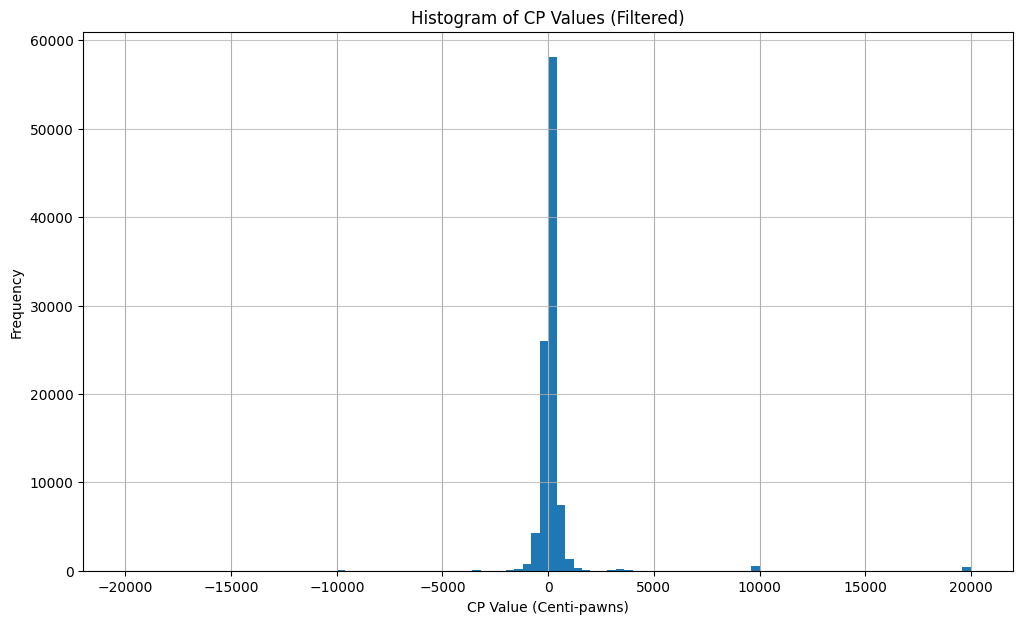

In [8]:
if not df.empty and 'cp' in df.columns and not df['cp'].empty:
    plt.figure(figsize=(12, 7))
    df['cp'].hist(bins=100) # Increased bins for potentially more detail
    plt.title('Histogram of CP Values (Filtered)')
    plt.xlabel('CP Value (Centi-pawns)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("Cannot plot histogram: DataFrame is empty or 'cp' column is missing/empty.")